# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process
    * With class conditioning
    * with batch norm to speed up training

In [1]:
!pip install --upgrade -q clu einops dm-haiku optax flax
!pip install --upgrade -q dm-tree graphviz imageio[ffmpeg]
!pip install -q tensorflow_datasets
!pip install -q tensorflow

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os
from flax import jax_utils

colab = False

if not colab:
  os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
  jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

In [3]:
train_new_model = False
cont=True
model_name = 'emnist_fixed_with_cond.jax_version.BatchNorm'

import os
import os.path as osp

if not colab:
  data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
  model_paths = osp.join(os.getcwd(), 'saved','saved_models')
  gifs_dir = osp.join(os.getcwd(), 'gifs')+"/"
  dataset_path = "tensorflow_datasets/"
else:
  data_paths = F"/EMNIST/data/"
  model_paths = F"/EMNIST/model/"
  gifs_dir = F"EMNIST/gifs/"
  dataset_path = F"/EMNIST/dataset/"

In [4]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.1)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [6]:
# Train model
timesteps = 250
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)
key = jax.random.PRNGKey(42)

# how to add noise to the data
@jax.jit
def get_noisy(rng, batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    # need to generate new keys everytime
    _, noise_key = jax.random.split(rng)
    noise_at_t = jax.random.normal(noise_key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = jnp.subtract(batch, noise*sd[timestep])/(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7fccbb42f1d0>],
 [<matplotlib.lines.Line2D at 0x7fccb8172c90>])

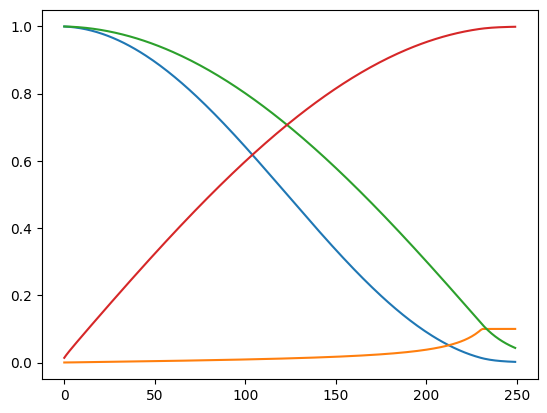

In [7]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_)), plt.plot(sd)

In [8]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib as mpl
import matplotlib.cm as cm
from clu import deterministic_data

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
  """Convert an array to an image.

  Arguments:
    arr : array-like The image data. The shape can be one of MxN (luminance),
      MxNx3 (RGB) or MxNx4 (RGBA).
    vmin : scalar, optional lower value.
    vmax : scalar, optional *vmin* and *vmax* set the color scaling for the
      image by fixing the values that map to the colormap color limits. If
      either *vmin* or *vmax* is None, that limit is determined from the *arr*
      min/max value.
    cmap : str or `~matplotlib.colors.Colormap`, optional A Colormap instance or
      registered colormap name. The colormap maps scalar data to colors. It is
      ignored for RGB(A) data.
        Defaults to :rc:`image.cmap` ('viridis').
    origin : {'upper', 'lower'}, optional Indicates whether the ``(0, 0)`` index
      of the array is in the upper
        left or lower left corner of the axes.  Defaults to :rc:`image.origin`
          ('upper').

  Returns:
    A uint8 image array.
  """
  sm = cm.ScalarMappable(cmap=cmap)
  sm.set_clim(vmin, vmax)
  if origin is None:
    origin = mpl.rcParams["image.origin"]
  if origin == "lower":
    arr = arr[::-1]
  rgba = sm.to_rgba(arr, bytes=True)
  return rgba

def rawarrview(array, **kwargs):
  """Visualize an array as if it was an image in colab notebooks.

  Arguments:
    array: an array which will be turned into an image.
    **kwargs: Additional keyword arguments passed to imify.
  """
  f = io.BytesIO()
  imarray = imify(array, **kwargs)
  plt.imsave(f, imarray, format="png")
  f.seek(0)
  dat = f.read()
  f.close()
  display_png(dat, raw=True)


def reshape_image_batch(array, cut=None, rows=None, axis=0):
  """Given an array of shape [n, x, y, ...] reshape it to create an image field.

  Arguments:
    array: The array to reshape.
    cut: Optional cut on the number of images to view. Will default to whole
      array.
    rows: Number of rows to use.  Will default to the integer less than the
      sqrt.
    axis: Axis to interpretate at the batch dimension.  By default the image
      dimensions immediately follow.

  Returns:
    reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
  """
  original_shape = array.shape
  assert len(original_shape) >= 2, "array must be at least 3 Dimensional."

  if cut is None:
    cut = original_shape[axis]
  if rows is None:
    rows = int(math.sqrt(cut))

  cols = cut // rows
  cut = cols * rows

  leading = original_shape[:axis]
  x_width = original_shape[axis + 1]
  y_width = original_shape[axis + 2]
  remaining = original_shape[axis + 3:]

  array = array[:cut]
  array = array.reshape(leading + (rows, cols, x_width, y_width) + remaining)
  array = np.moveaxis(array, axis + 2, axis + 1)
  array = array.reshape(leading + (rows * x_width, cols * y_width) + remaining)
  return array

def zoom(im, k, axes=(0, 1)):
  for ax in axes:
    im = np.repeat(im, k, ax)
  return im


def imgviewer(im, zoom=3, cmap='bone_r', normalize=False, **kwargs):
  if normalize:
    im = im - im.min()
    im = im / im.max()
  return rawarrview(zoom(im, zoom), cmap=cmap, **kwargs)

# replicate = flax.jax_utils.replicate
# unreplicate = flax.jax_utils.unreplicate

In [9]:
#@title data

dataset_builder = tfds.builder('emnist', data_dir=dataset_path)
dataset_builder.download_and_prepare()

train_split = tfds.split_for_jax_process('train+train', drop_remainder=True)

def preprocess_fn(example):
  image = tf.cast(example['image'], 'float32')
  image = tf.transpose(image, (1, 0, 2,))
  image = image / 255.0
  return (image, example["label"] + 1)

batch_size = 4 * 128 if colab else 64
train_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=train_split,
    rng=jax.random.PRNGKey(0),
    shuffle_buffer_size=100,
    batch_dims=[jax.local_device_count(), batch_size // jax.device_count()],
    num_epochs=None,
    preprocess_fn=lambda x: preprocess_fn(x),
    shuffle=True)

def create_input_iter(ds):
  def _prepare(xs):
    def _f(x):
      x = x._numpy()
      return x
    return jax.tree_util.tree_map(_f, xs)
  it = map(_prepare, ds)
  it = jax_utils.prefetch_to_device(it, 2)
  return it

I0000 00:00:1756929631.848671    4939 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-09-03 16:00:32.182441: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykernel_launcher.runfiles/cuda_nvdisasm
  ipykernel_launcher.runfiles/nvidia_nvshmem
  ipykern/cuda_nvcc
  ipykern/cuda_nvdisasm
  ipykern/nvidia_nvshmem
  
  /usr/local/cuda
  /opt/cuda
  /home/golongson/miniconda3/envs/dl/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/golongson/miniconda3/envs/dl/lib/python3.11

2025-09-03 16:00:32.889329: E tensorflow/core/util/util.cc:131] oneDNN supports DT_UINT8 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


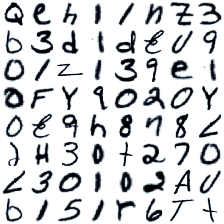

In [10]:
out = next(create_input_iter(train_ds))
rawarrview(reshape_image_batch(out[0][0].squeeze()), cmap='bone_r')

In [11]:
# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
@jax.jit
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.mean(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

# Recommended: this can be jit'd and it should result in faster training time 
partial(jax.jit,  static_argnums=(4,))
def compute_loss(params: hk.Params, state: hk.State, batch: Batch, is_energy_method: bool=False, is_training=False) -> Tuple[jnp.ndarray, Tuple[jnp.ndarray, hk.State]]:
  """Compute the loss of the network, including L2."""
  x, label, timestep, noise = batch
  # not capturing state as it is not needed; it should be internally updated and maintaing by haiku and doesn't need gradient updates 
  pred_data, state = net.apply(params, state, x, timestep, label, is_training)
  
  def error_func():
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.mean(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.mean(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_, (loss_, state)

@jax.jit
def update(
    params: hk.Params,
    state: hk.State,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False) -> Tuple[jnp.ndarray, hk.Params, optax.OptState, hk.State]:
  """Compute gradients and update the weights"""
  grads, (loss_value, state)= jax.grad(compute_loss, has_aux=True)(params, state, batch, is_energy_method, is_training=True)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state, state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def unnormalize(images):
  return images*255.
  

In [12]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
# batch_size=512
# train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [13]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(create_input_iter(train_ds))[0][0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(key, einops.repeat(image, 'h w c -> b h w c', b=timesteps//5), jnp.arange(1, timesteps, 5))
if colab:
  noisy_images = einops.rearrange(noisy_images, 'b h w c -> b h (w c)')
noisy_images = unnormalize(noisy_images)

for i in range(timesteps//10):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir+'diffusion.gif', writer='pillow')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  if colab:
    img = einops.rearrange(img, 'h w c -> h (w c)')
  plt_.imshow(img, cmap="gray", animated=False)

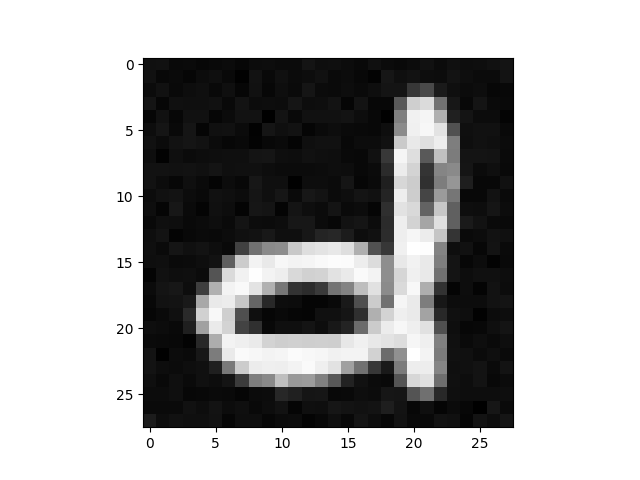

In [14]:
with open(gifs_dir + 'diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [15]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return self.conv(x)
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return self.conv(x)
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.proj = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME', with_bias=False)
    # using batch norm instead of layernorm as the batch sizes are large
    # orig: self.norm = hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True)
    self.norm = hk.BatchNorm(True, True, decay_rate=0.9)
    self.silu = jax.nn.silu
    self.conv1 = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME', with_bias=False)
    self.norm1 = hk.BatchNorm(True, True, decay_rate=0.9)
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      jax.nn.silu,
      hk.Linear(dims*2),
    ])
    
  def __call__(self, x, timestep_embeddings=None, is_training=False):
    h = self.proj(x)
    h = self.norm(h, is_training)
    if timestep_embeddings is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timestep_embeddings)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      h = shift + (scale+1)*h
    
    h = self.silu(self.norm1(self.conv1(self.silu(h)), is_training))
    return self.out_conv(x) + h

In [16]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=48, kernel_shape = (5,5), padding='SAME', with_bias=False)
    self.norm = hk.BatchNorm(True, True, decay_rate=0.9)
    self.silu = jax.nn.silu
    self.block1 = Block(output_channels=48, kernel_size=3, padding=1)
    self.downsample1 = Downsample(96)
    self.block2 = Block(output_channels=96, kernel_size=3, padding=1)
    self.downsample2 = Downsample(192)
    self.middle_block = Block(output_channels=192, kernel_size=3, padding=1)
    self.upsample1 = Upsample(96)
    self.block3 = Block(output_channels=96, kernel_size=3, padding=1)
    self.upsample2 = Upsample(48)
    self.block4 = Block(output_channels=48, kernel_size=3, padding=1)
    self.conv1 = hk.Conv2D(output_channels=48, kernel_shape = (3,3), padding='SAME', with_bias=False)
    self.norm1 = hk.BatchNorm(True, True, decay_rate=0.9)
    self.conv2 = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
    
    self.time_mlp = hk.Sequential([
      hk.Linear(256),
      jax.nn.gelu,
      hk.Linear(256),
    ])
    # conditional vectors encoding
    self.embedding_vectors = hk.Embed(10+26+26+1, 63)
    self.timestep_embeddings = TimeEmbeddings(96)
      
  def __call__(self, x, timesteps, cond=None, is_training=False):
    cond_embedding = None
    conditioning = None
    if timesteps is not None:
      timestep_embeddings = self.timestep_embeddings(timesteps)
      conditioning = timestep_embeddings
    if cond is not None:
      label_embeddings = self.embedding_vectors(cond)
      conditioning = jnp.concatenate([label_embeddings, conditioning], axis=1)
    if conditioning is not None:  
      cond_embedding = self.time_mlp(conditioning)
    h = self.silu(self.norm(self.init_conv(x), is_training))
    xx = jnp.copy(h)
    b1 = self.block1(h, cond_embedding, is_training)
    h = self.downsample1(b1)
    b2 = self.block2(h, cond_embedding, is_training)
    h = self.downsample2(b2)
    h = self.upsample1(self.middle_block(h, cond_embedding, is_training))
    b3 = self.block3(jnp.concatenate((h, b2), axis=3), cond_embedding, is_training)
    h = self.upsample2(b3)
    b4 = self.block4(jnp.concatenate((h, b1), axis=3), cond_embedding, is_training)
    h = self.conv2(self.silu(self.norm1(self.conv1(jnp.concatenate((xx, b4), axis=3)), is_training)))
    return h

In [17]:
def save(ckpt_dir: str, params, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_state.pkl"), "wb") as f:
     pickle.dump(state, f)
      
  with open(os.path.join(ckpt_dir, model_name+"_params.pkl"), "wb") as f:
     pickle.dump(params, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_state.pkl"), "rb") as f:
    state = pickle.load(f)
 
  with open(os.path.join(ckpt_dir, model_name+"_params.pkl"), "rb") as f:
    params = pickle.load(f)
    
  return params, state

def test_model_save():
  save('saved/saved_models/', avg_params, state, 'emnist_model')
  avg_params, state = restore('saved/saved_models/', 'emnist_model')

In [18]:
import graphviz

def f(x, timesteps, label, is_training):
  unet = UNet()
  return unet(x, timesteps, label, is_training)

f_t = hk.transform_with_state(f)
net = hk.without_apply_rng(f_t)

image, label = next(create_input_iter(train_ds)) #jnp.ones([100, 28, 28, 1])
timesteps_ = jnp.arange(0, batch_size)

_, rng = jax.random.split(key)

if cont and os.path.exists(osp.join(model_paths, model_name + '_state.pkl')):
  avg_params, state = restore(model_paths, model_name)
  params = deepcopy(avg_params)
else:
  params, state = net.init(rng, image[0][0:batch_size], timesteps_, label[0][0:batch_size], is_training=True)

opt = optax.adam(1e-3)

avg_params = deepcopy(params)
opt_state = opt.init(params)



---




### Training

In [19]:
def show_predicted_image(noisy_image, params, timestep, state, label=None):
  print('time step for image: ', timestep, ' label: ', label)
  timestep = jnp.array([timestep])
  pred_noise, _ = net.apply(params, state, noisy_image, timestep, label, is_training=False)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

In [20]:
b, l = image[0], label[0] # next(create_input_iter(train_ds))[0]

unique_key = jax.random.fold_in(key, jnp.sum(b))
_, *subkeys = jax.random.split(unique_key, timesteps)

time step for image:  249  label:  [2]


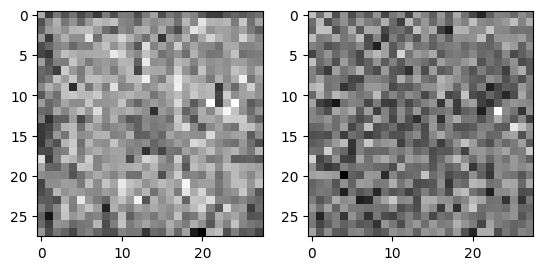

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

[32.838123]


In [21]:
def test_loss_fn():
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(subkeys[i-1], b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, state, [data_noisy_temp[0:1], l[0:1], tt, 
                                                          noise_temp[0:1]], is_energy_method=False, is_training=False)[0]))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp, _ = net.apply(avg_params, state, data_noisy_temp[0:1], tt, l[0:1], is_training=False)
    reconstructed = recover_original(data_noisy_temp[0:1], tt, pp)
    model_huber_loss.append(huber_loss(reconstructed[0:1], data_noisy_temp[0:1]))
    
  print(show_predicted_image(data_noisy_temp[0:1], avg_params, i, state, l[0:1]))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

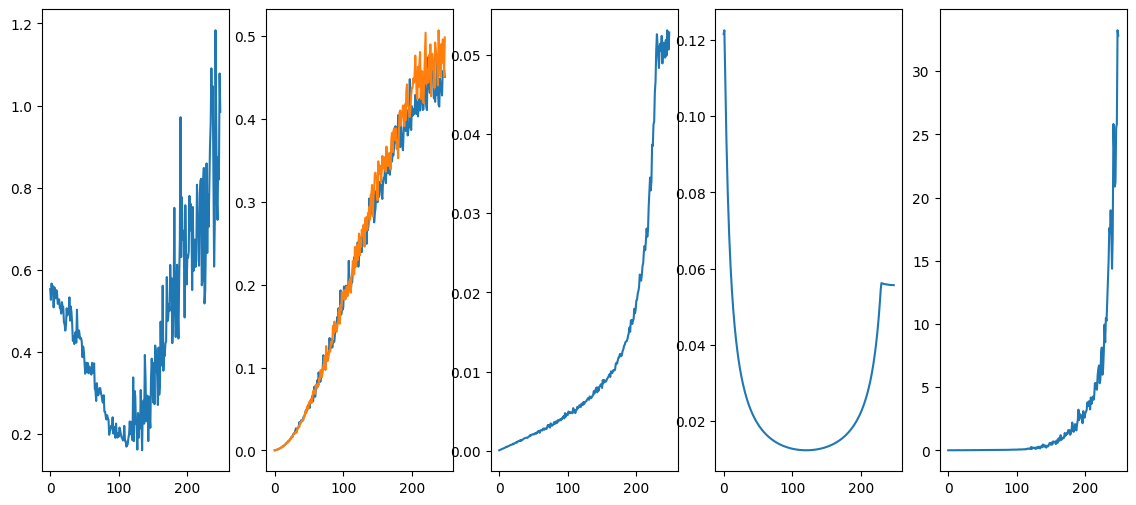

In [22]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [23]:
from copy import deepcopy
import pickle
import sys

batches_iter = 10000
one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
train = create_input_iter(train_ds) 
data_in_batch_, label_ = next(train)
data_in_batch_ = data_in_batch_[0]
label_ = label_[0]
data_noisy_temp_, noise_temp_ = get_noisy(key, data_in_batch_, one_timestep)

def train_model(opt_state, params, avg_params, state, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization   

    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        # generating sub keys for timesteps
        unique_key = jax.random.fold_in(key, batch_size)
        
        # same subkey being used for noise sampling, as it doesn't matter :)
        _, *timestep_subkeys = jax.random.split(unique_key, batches_iter+1)
        
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = data_in_batch[0]
            label = label[0]
            idx = (jax.random.uniform(key=timestep_subkeys[iteration], shape=(batch_size, 1)) * (timesteps-1)).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(timestep_subkeys[iteration], data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state, state = update(params, state, opt_state, [data_noisy, label, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:
              print("batch loss value: ", loss_value)
            
            if iteration % 20 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                loss_temp, _ = jax.device_get(compute_loss(avg_params, state, [data_noisy_temp_, label_, one_timestep, noise_temp_], energy_method, is_training=False))
                losses.append(loss_temp)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration: {iteration} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, state, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
            
                if iteration % 100 == 0:
                    print(f"iteration: {iteration} loss: {loss_temp:>7f}")
                    # sample a random number
                    r_ = (jax.random.uniform(timestep_subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(data_noisy_temp_[r_: r_+1], avg_params, one_timestep[r_], state, label_[r_: r_+1])

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params, state = restore(model_paths, model_name)
        params = deepcopy(avg_params)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params, state

batch loss value:  0.27482867


/tmp/ipykernel_4939/1279797340.py:44: RuntimeWarning: overflow encountered in cast
  if loss_temp < best_loss:


saving iteration: 0 loss: 1.029818
iteration: 0 loss: 1.029818
time step for image:  12  label:  [2]


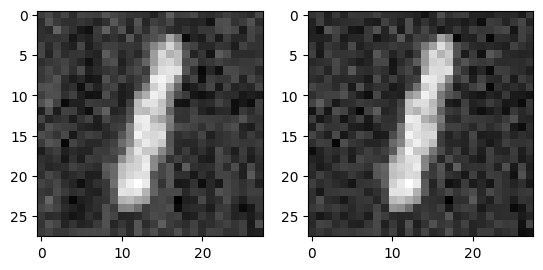

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.117207974
batch loss value:  0.07100888
saving iteration: 20 loss: 0.225174
batch loss value:  0.07905167
batch loss value:  0.05769776
saving iteration: 40 loss: 0.135087
batch loss value:  0.049877856
batch loss value:  0.05983178
saving iteration: 60 loss: 0.124176
batch loss value:  0.045919266
batch loss value:  0.04204051
saving iteration: 80 loss: 0.104608
batch loss value:  0.033759486
batch loss value:  0.031216394
saving iteration: 100 loss: 0.081454
iteration: 100 loss: 0.081454
time step for image:  15  label:  [9]


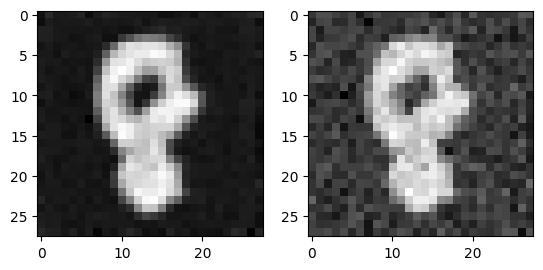

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.032606263
batch loss value:  0.03280124
batch loss value:  0.044661887
batch loss value:  0.03183074
saving iteration: 140 loss: 0.081304
batch loss value:  0.030387366
batch loss value:  0.029725337
saving iteration: 160 loss: 0.068920
batch loss value:  0.0327669
batch loss value:  0.023837704
saving iteration: 180 loss: 0.060547
batch loss value:  0.03190305
batch loss value:  0.026018795
saving iteration: 200 loss: 0.060143
iteration: 200 loss: 0.060143
time step for image:  33  label:  [50]


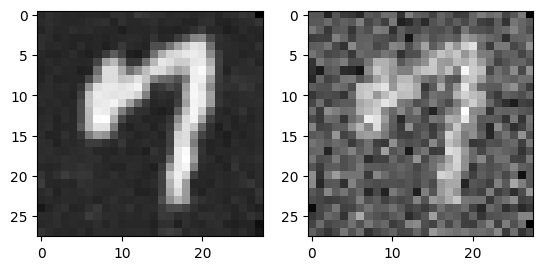

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.026675232
batch loss value:  0.023842238
saving iteration: 220 loss: 0.057226
batch loss value:  0.021929413
batch loss value:  0.025451723
batch loss value:  0.022827502
batch loss value:  0.02251961
saving iteration: 260 loss: 0.054238
batch loss value:  0.029138058
batch loss value:  0.023131603
saving iteration: 280 loss: 0.050261
batch loss value:  0.03183854
batch loss value:  0.025084011
iteration: 300 loss: 0.050436
time step for image:  48  label:  [16]


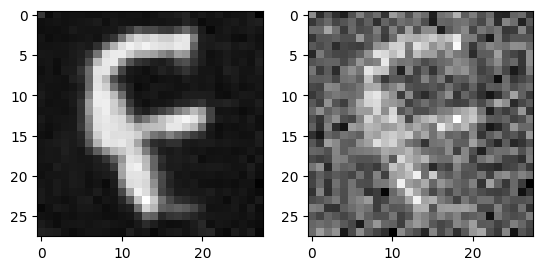

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.02224188
batch loss value:  0.020592438
saving iteration: 320 loss: 0.048371
batch loss value:  0.025812412
batch loss value:  0.022294287
batch loss value:  0.021703757
batch loss value:  0.019453712
saving iteration: 360 loss: 0.046954
batch loss value:  0.02592321
batch loss value:  0.022060875
batch loss value:  0.020836549
batch loss value:  0.018699571
saving iteration: 400 loss: 0.046533
iteration: 400 loss: 0.046533
time step for image:  31  label:  [7]


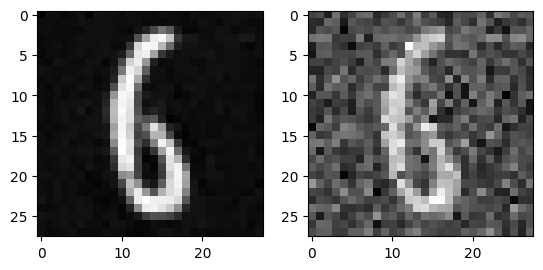

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.02034096
batch loss value:  0.026123725
saving iteration: 420 loss: 0.044362
batch loss value:  0.019622268
batch loss value:  0.02260916
batch loss value:  0.025444549
batch loss value:  0.021038817
batch loss value:  0.01952368
batch loss value:  0.024284389
saving iteration: 480 loss: 0.043687
batch loss value:  0.02063192
batch loss value:  0.020291883
iteration: 500 loss: 0.046157
time step for image:  54  label:  [15]


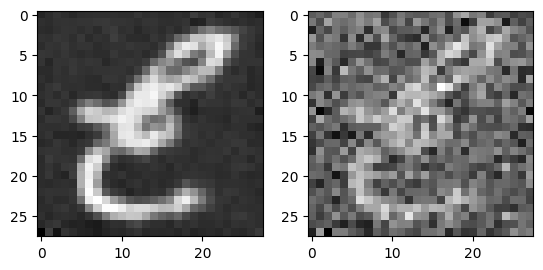

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01734237
batch loss value:  0.021664444
saving iteration: 520 loss: 0.043186
batch loss value:  0.02194361
batch loss value:  0.019504033
batch loss value:  0.022294646
batch loss value:  0.019959664
batch loss value:  0.017967155
batch loss value:  0.022167476
batch loss value:  0.017216153
batch loss value:  0.0219355
saving iteration: 600 loss: 0.042192
iteration: 600 loss: 0.042192
time step for image:  21  label:  [37]


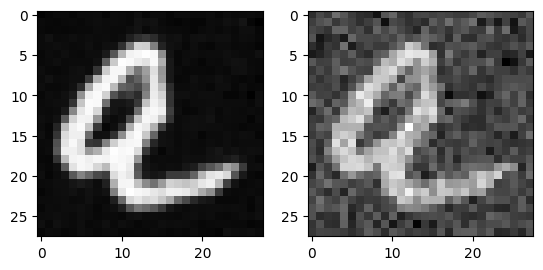

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.019922815
batch loss value:  0.016865049
batch loss value:  0.022441918
batch loss value:  0.017309207
saving iteration: 640 loss: 0.041197
batch loss value:  0.019006811
batch loss value:  0.023143072
batch loss value:  0.01594776
batch loss value:  0.018083552
batch loss value:  0.019269643
batch loss value:  0.018269412
saving iteration: 700 loss: 0.040811
iteration: 700 loss: 0.040811
time step for image:  51  label:  [37]


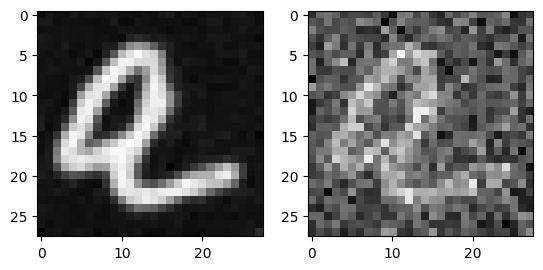

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.021662321
batch loss value:  0.019005198
batch loss value:  0.017389037
batch loss value:  0.017542224
batch loss value:  0.019465331
batch loss value:  0.022253752
saving iteration: 760 loss: 0.039922
batch loss value:  0.018786257
batch loss value:  0.020254627
batch loss value:  0.02213082
batch loss value:  0.026592977
iteration: 800 loss: 0.041818
time step for image:  62  label:  [37]


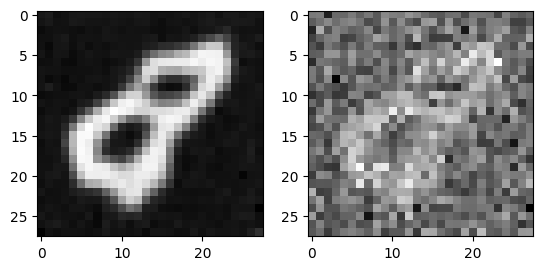

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016412057
batch loss value:  0.020196257
batch loss value:  0.01770337
batch loss value:  0.017340867
batch loss value:  0.020466495
batch loss value:  0.018964577
batch loss value:  0.017372016
batch loss value:  0.016882285
batch loss value:  0.019544426
batch loss value:  0.018412806
iteration: 900 loss: 0.040104
time step for image:  51  label:  [37]


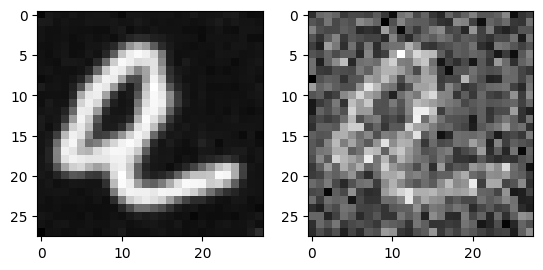

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.02016033
batch loss value:  0.01957285
saving iteration: 920 loss: 0.039630
batch loss value:  0.017892897
batch loss value:  0.0185842
batch loss value:  0.015534269
batch loss value:  0.017177429
batch loss value:  0.02375799
batch loss value:  0.019741364
batch loss value:  0.01868907
batch loss value:  0.01768793
iteration: 1000 loss: 0.041445
time step for image:  61  label:  [36]


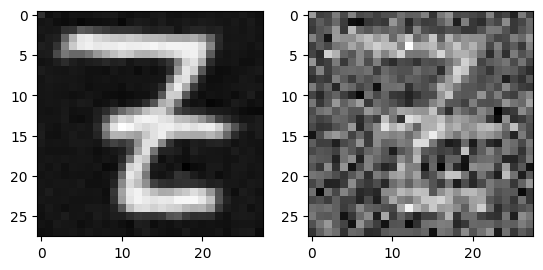

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.022266602
batch loss value:  0.018142547
saving iteration: 1020 loss: 0.039158
batch loss value:  0.01922161
batch loss value:  0.018974796
saving iteration: 1040 loss: 0.038470
batch loss value:  0.021129066
batch loss value:  0.021458708
batch loss value:  0.017941719
batch loss value:  0.014547367
batch loss value:  0.019686006
batch loss value:  0.018594401
saving iteration: 1100 loss: 0.038397
iteration: 1100 loss: 0.038397
time step for image:  12  label:  [2]


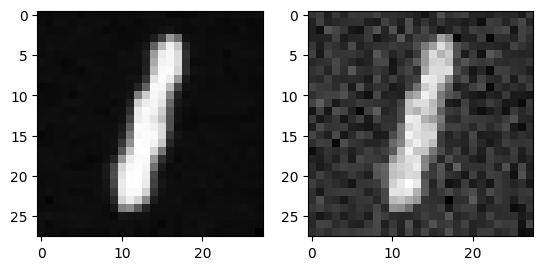

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.021553006
batch loss value:  0.022557367
batch loss value:  0.020637412
batch loss value:  0.018541962
batch loss value:  0.017248698
batch loss value:  0.015573732
batch loss value:  0.017128356
batch loss value:  0.018100008
batch loss value:  0.020050157
batch loss value:  0.013386605
iteration: 1200 loss: 0.042960
time step for image:  53  label:  [3]


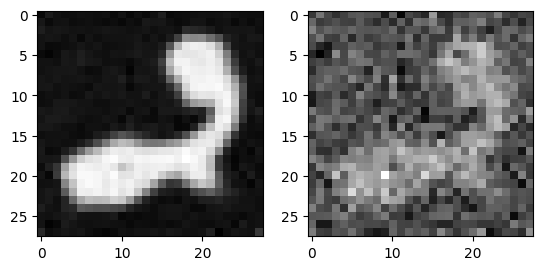

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.019114291
batch loss value:  0.019469317
saving iteration: 1220 loss: 0.038368
batch loss value:  0.018149292
batch loss value:  0.017314903
batch loss value:  0.019487537
batch loss value:  0.021958103
batch loss value:  0.015609395
batch loss value:  0.01699194
saving iteration: 1280 loss: 0.037898
batch loss value:  0.015866442
batch loss value:  0.018784333
iteration: 1300 loss: 0.038833
time step for image:  56  label:  [2]


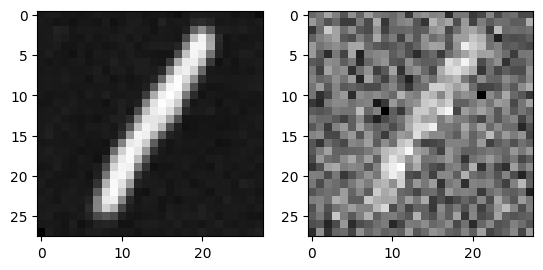

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01985737
batch loss value:  0.018776702
batch loss value:  0.01791756
batch loss value:  0.017843146
batch loss value:  0.017943887
batch loss value:  0.016935434
batch loss value:  0.015362395
batch loss value:  0.014876274
saving iteration: 1380 loss: 0.037239
batch loss value:  0.01698156
batch loss value:  0.018498754
iteration: 1400 loss: 0.038525
time step for image:  32  label:  [40]


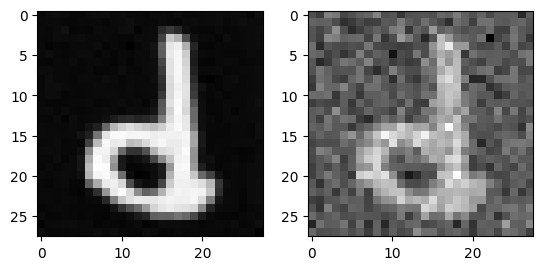

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016609654
batch loss value:  0.014420636
batch loss value:  0.020625517
batch loss value:  0.016722105
batch loss value:  0.019681787
batch loss value:  0.016456433
batch loss value:  0.017752156
batch loss value:  0.016772922
batch loss value:  0.015241869
batch loss value:  0.01798522
iteration: 1500 loss: 0.038402
time step for image:  50  label:  [60]


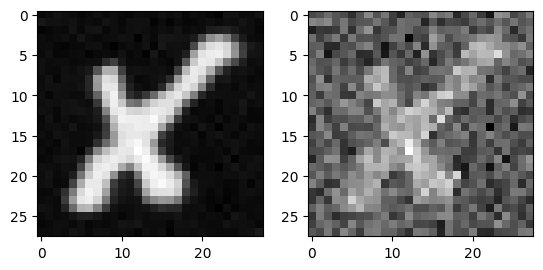

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.017592499
batch loss value:  0.014476286
batch loss value:  0.01328468
batch loss value:  0.015619755
batch loss value:  0.020289207
batch loss value:  0.019474346
batch loss value:  0.01767136
batch loss value:  0.017037734
batch loss value:  0.016977869
batch loss value:  0.018093511
iteration: 1600 loss: 0.037569
time step for image:  58  label:  [37]


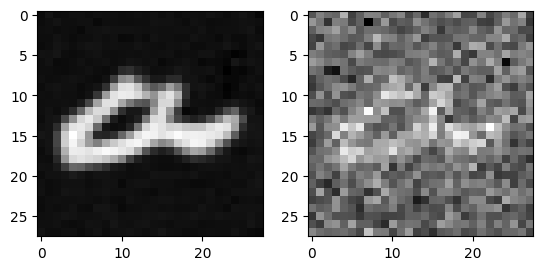

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.019666735
batch loss value:  0.016486965
batch loss value:  0.016598469
batch loss value:  0.016874095
saving iteration: 1640 loss: 0.036847
batch loss value:  0.014517877
batch loss value:  0.018040776
batch loss value:  0.016266573
batch loss value:  0.014341436
batch loss value:  0.01558625
batch loss value:  0.014589808
iteration: 1700 loss: 0.038124
time step for image:  48  label:  [16]


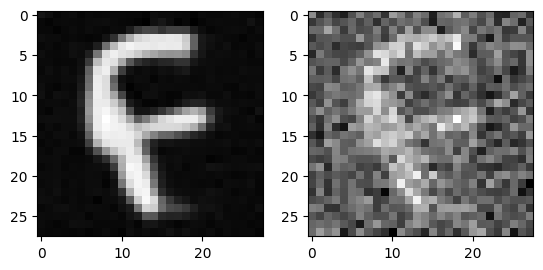

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.018054366
batch loss value:  0.014024202
batch loss value:  0.019326342
batch loss value:  0.015782088
batch loss value:  0.014065726
batch loss value:  0.016926609
batch loss value:  0.020128177
batch loss value:  0.015631717
batch loss value:  0.01827883
batch loss value:  0.015012002
iteration: 1800 loss: 0.039705
time step for image:  48  label:  [16]


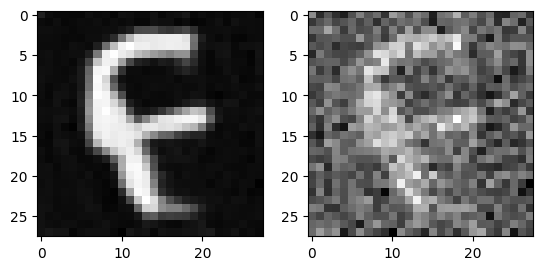

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.017790642
batch loss value:  0.014993301
saving iteration: 1820 loss: 0.036625
batch loss value:  0.015825592
batch loss value:  0.021421973
batch loss value:  0.017466292
batch loss value:  0.018138869
saving iteration: 1860 loss: 0.036393
batch loss value:  0.015433343
batch loss value:  0.015468708
batch loss value:  0.022551473
batch loss value:  0.016359393
iteration: 1900 loss: 0.038405
time step for image:  36  label:  [50]


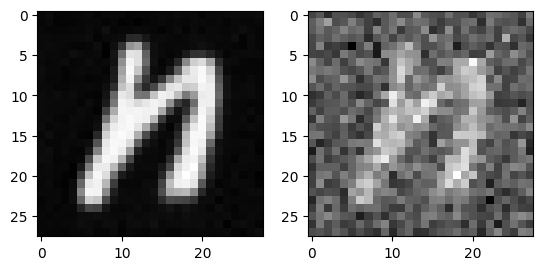

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.018728118
batch loss value:  0.018079773
batch loss value:  0.019423414
batch loss value:  0.01847795
batch loss value:  0.017875016
batch loss value:  0.013715873
batch loss value:  0.014582131
batch loss value:  0.020490747
batch loss value:  0.014795246
batch loss value:  0.017027406
saving iteration: 2000 loss: 0.035943
iteration: 2000 loss: 0.035943
time step for image:  10  label:  [44]


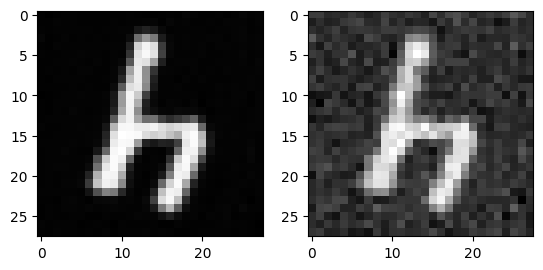

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.02194828
batch loss value:  0.014375351
batch loss value:  0.013513494
batch loss value:  0.014399941
batch loss value:  0.01726516
batch loss value:  0.01358689
batch loss value:  0.016325146
batch loss value:  0.01491417
batch loss value:  0.020825408
batch loss value:  0.016865829
iteration: 2100 loss: 0.036523
time step for image:  32  label:  [40]


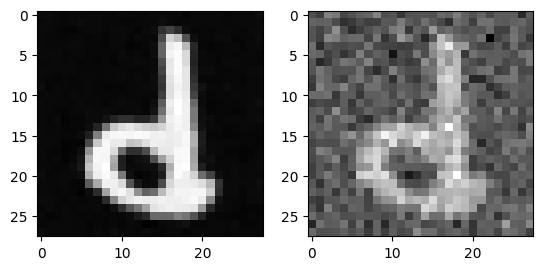

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.017859071
batch loss value:  0.01481227
batch loss value:  0.020695562
batch loss value:  0.014955698
batch loss value:  0.018662859
batch loss value:  0.02045926
batch loss value:  0.015802652
batch loss value:  0.02027683
batch loss value:  0.014134804
batch loss value:  0.021226706
iteration: 2200 loss: 0.038777
time step for image:  32  label:  [40]


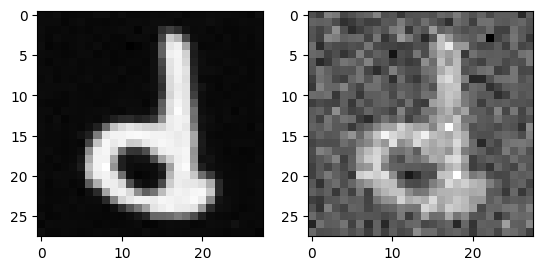

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01944178
batch loss value:  0.017611997
batch loss value:  0.015736558
batch loss value:  0.025532618
batch loss value:  0.020998763
batch loss value:  0.015710955
batch loss value:  0.014959433
batch loss value:  0.014217919
batch loss value:  0.0164983
batch loss value:  0.01844604
iteration: 2300 loss: 0.036460
time step for image:  3  label:  [35]


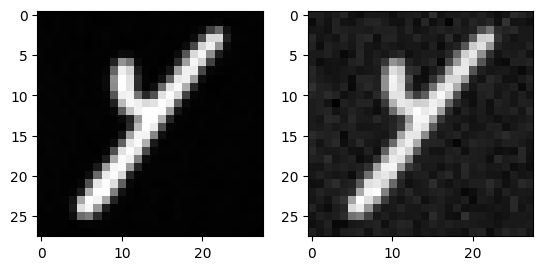

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013939902
batch loss value:  0.018010672
batch loss value:  0.019680545
batch loss value:  0.018136548
batch loss value:  0.016766723
batch loss value:  0.021261958
batch loss value:  0.015690818
batch loss value:  0.017549675
batch loss value:  0.015601219
batch loss value:  0.016766617
saving iteration: 2400 loss: 0.035929
iteration: 2400 loss: 0.035929
time step for image:  4  label:  [7]


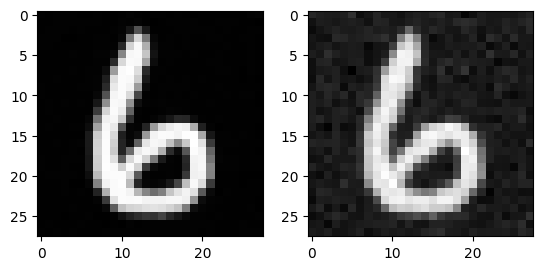

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014851132
batch loss value:  0.01788937
batch loss value:  0.017944615
batch loss value:  0.018674789
saving iteration: 2440 loss: 0.035446
batch loss value:  0.018033225
batch loss value:  0.016337376
batch loss value:  0.017373664
batch loss value:  0.015023767
batch loss value:  0.015717378
batch loss value:  0.017671548
iteration: 2500 loss: 0.041423
time step for image:  54  label:  [15]


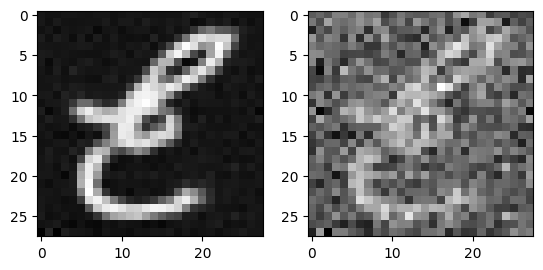

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.017889854
batch loss value:  0.014044914
batch loss value:  0.015403175
batch loss value:  0.013254138
batch loss value:  0.014765694
batch loss value:  0.015959403
batch loss value:  0.01902661
batch loss value:  0.016085416
batch loss value:  0.016416112
batch loss value:  0.017152179
iteration: 2600 loss: 0.036001
time step for image:  7  label:  [8]


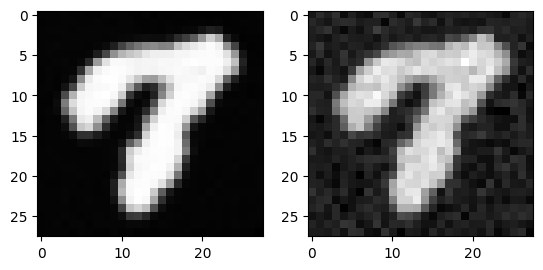

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.012516313
batch loss value:  0.0154428
batch loss value:  0.016626278
batch loss value:  0.014251603
batch loss value:  0.015265619
batch loss value:  0.017148456
batch loss value:  0.018154148
batch loss value:  0.014007475
batch loss value:  0.015656754
batch loss value:  0.018262845
iteration: 2700 loss: 0.035871
time step for image:  40  label:  [10]


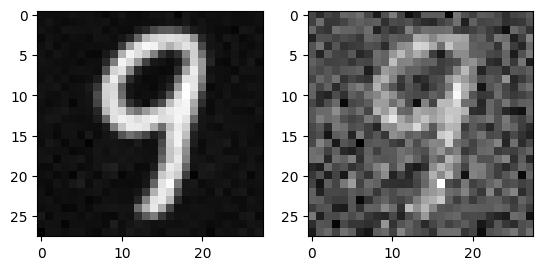

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.021087045
batch loss value:  0.016915407
batch loss value:  0.01772492
batch loss value:  0.012179026
batch loss value:  0.018598678
batch loss value:  0.014458377
batch loss value:  0.019565374
batch loss value:  0.017109778
batch loss value:  0.016461466
batch loss value:  0.015003789
iteration: 2800 loss: 0.036246
time step for image:  33  label:  [50]


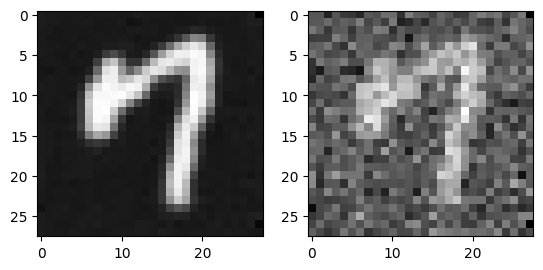

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014106498
batch loss value:  0.013373801
batch loss value:  0.014776993
batch loss value:  0.018200789
batch loss value:  0.016872479
batch loss value:  0.012963217
batch loss value:  0.014313467
batch loss value:  0.019128876
batch loss value:  0.01473283
batch loss value:  0.014359044
iteration: 2900 loss: 0.036342
time step for image:  7  label:  [8]


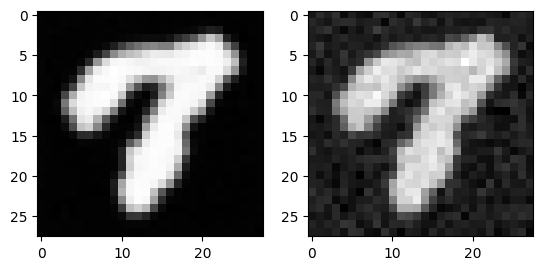

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013193157
batch loss value:  0.014003752
batch loss value:  0.014655079
batch loss value:  0.016978221
saving iteration: 2940 loss: 0.035388
batch loss value:  0.016601361
batch loss value:  0.015663423
batch loss value:  0.013443392
batch loss value:  0.014030578
batch loss value:  0.018003639
batch loss value:  0.017698757
iteration: 3000 loss: 0.035413
time step for image:  35  label:  [7]


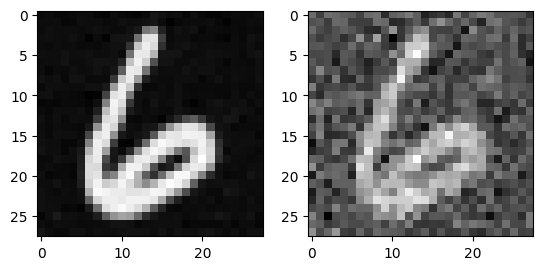

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.019238584
batch loss value:  0.016185343
batch loss value:  0.013718679
batch loss value:  0.016792234
batch loss value:  0.01730415
batch loss value:  0.014163904
batch loss value:  0.016550332
batch loss value:  0.018075407
batch loss value:  0.014608898
batch loss value:  0.016259886
iteration: 3100 loss: 0.035740
time step for image:  42  label:  [9]


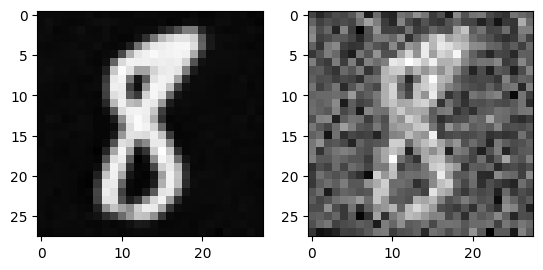

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.018436933
batch loss value:  0.014096979
batch loss value:  0.015095051
batch loss value:  0.01344798
batch loss value:  0.01625032
batch loss value:  0.014896145
batch loss value:  0.014500455
batch loss value:  0.014390927
saving iteration: 3180 loss: 0.034495
batch loss value:  0.015485475
batch loss value:  0.018642277
iteration: 3200 loss: 0.036347
time step for image:  41  label:  [1]


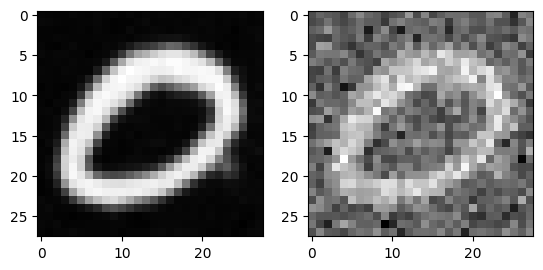

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014716737
batch loss value:  0.017753612
batch loss value:  0.01736451
batch loss value:  0.012956817
batch loss value:  0.01630743
batch loss value:  0.015416383
batch loss value:  0.015003869
batch loss value:  0.014807218
batch loss value:  0.014399333
batch loss value:  0.021507272
iteration: 3300 loss: 0.036503
time step for image:  1  label:  [22]


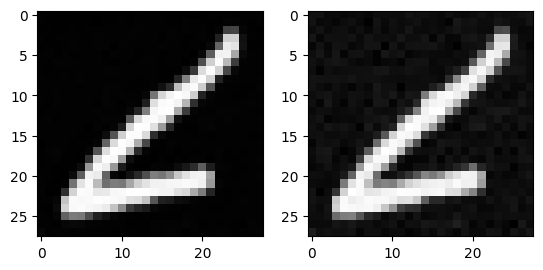

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016638827
batch loss value:  0.015855743
batch loss value:  0.01860859
batch loss value:  0.014034554
batch loss value:  0.017966226
batch loss value:  0.016260238
batch loss value:  0.017855778
batch loss value:  0.014959056
batch loss value:  0.015607049
batch loss value:  0.014563376
iteration: 3400 loss: 0.036339
time step for image:  38  label:  [3]


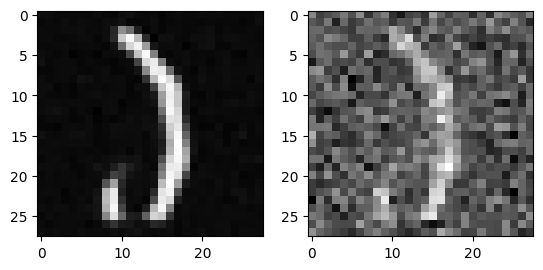

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.020099774
batch loss value:  0.015238719
batch loss value:  0.015175344
batch loss value:  0.017064158
batch loss value:  0.014711039
batch loss value:  0.013101241
batch loss value:  0.014245456
batch loss value:  0.014054065
batch loss value:  0.014168347
batch loss value:  0.018686023
iteration: 3500 loss: 0.037119
time step for image:  45  label:  [19]


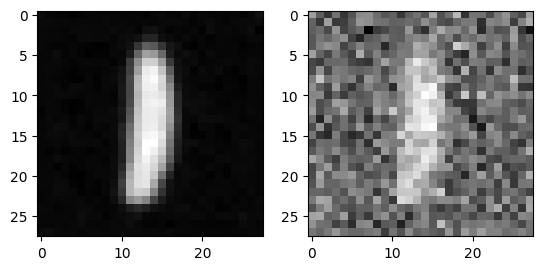

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014467228
batch loss value:  0.012891655
batch loss value:  0.016430952
batch loss value:  0.01580745
batch loss value:  0.015687408
batch loss value:  0.015447349
batch loss value:  0.015256337
batch loss value:  0.017084014
batch loss value:  0.016942305
batch loss value:  0.016686115
iteration: 3600 loss: 0.034628
time step for image:  5  label:  [43]


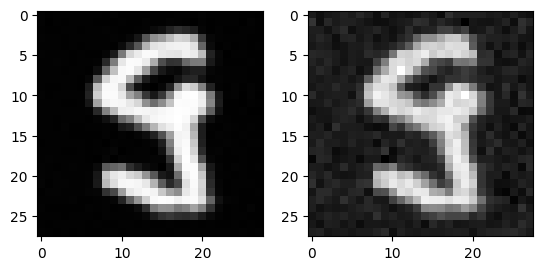

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.017027346
batch loss value:  0.01489033
batch loss value:  0.017779123
batch loss value:  0.01369045
batch loss value:  0.015619429
batch loss value:  0.014965797
batch loss value:  0.016075937
batch loss value:  0.014702221
batch loss value:  0.013478009
batch loss value:  0.018356932
iteration: 3700 loss: 0.034581
time step for image:  40  label:  [10]


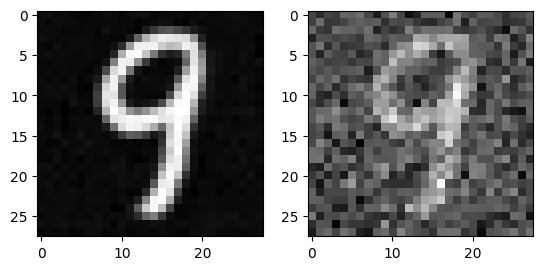

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.0127300015
batch loss value:  0.015089072
batch loss value:  0.016920954
batch loss value:  0.014953624
batch loss value:  0.017215556
batch loss value:  0.013058443
batch loss value:  0.015865797
batch loss value:  0.017473407
saving iteration: 3780 loss: 0.034202
batch loss value:  0.02318433
batch loss value:  0.016377334
iteration: 3800 loss: 0.036085
time step for image:  40  label:  [10]


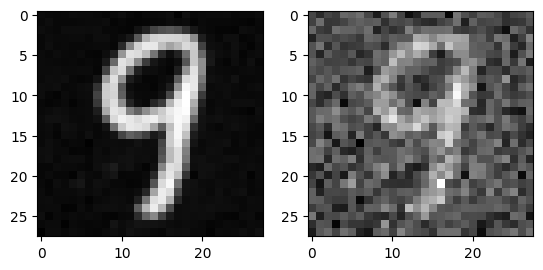

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015953068
batch loss value:  0.016954111
batch loss value:  0.015667142
batch loss value:  0.012937214
batch loss value:  0.01655094
batch loss value:  0.018957995
batch loss value:  0.015522072
batch loss value:  0.011974473
batch loss value:  0.016701546
batch loss value:  0.0148551725
iteration: 3900 loss: 0.034766
time step for image:  1  label:  [22]


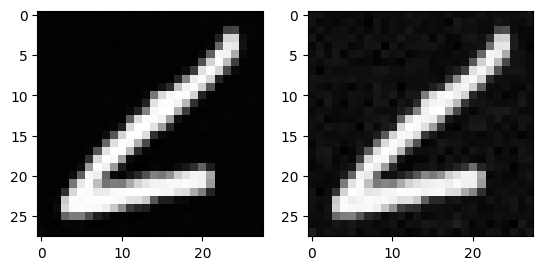

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013692062
batch loss value:  0.014640792
batch loss value:  0.012267473
batch loss value:  0.014000284
batch loss value:  0.014435273
batch loss value:  0.012264183
batch loss value:  0.01617708
batch loss value:  0.0164179
batch loss value:  0.0148572605
batch loss value:  0.014730405
iteration: 4000 loss: 0.036057
time step for image:  45  label:  [19]


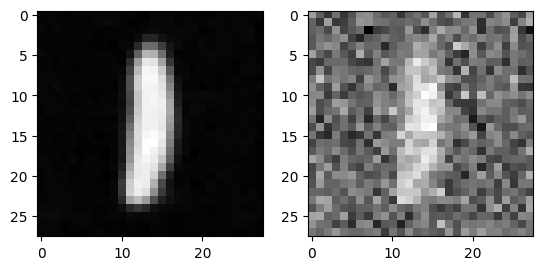

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013411339
batch loss value:  0.014204172
batch loss value:  0.01842656
batch loss value:  0.01750878
batch loss value:  0.010922318
batch loss value:  0.018038876
batch loss value:  0.015514173
batch loss value:  0.01390991
batch loss value:  0.016500741
batch loss value:  0.014899489
iteration: 4100 loss: 0.035099
time step for image:  64  label:  [8]


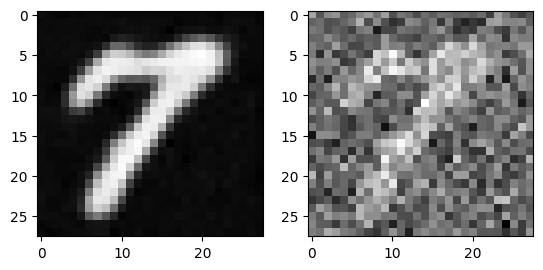

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013851372
batch loss value:  0.015767619
saving iteration: 4120 loss: 0.034096
batch loss value:  0.012970643
batch loss value:  0.014641535
batch loss value:  0.016141059
batch loss value:  0.013913606
batch loss value:  0.017505668
batch loss value:  0.013220858
batch loss value:  0.011932663
batch loss value:  0.01938739
iteration: 4200 loss: 0.034578
time step for image:  37  label:  [1]


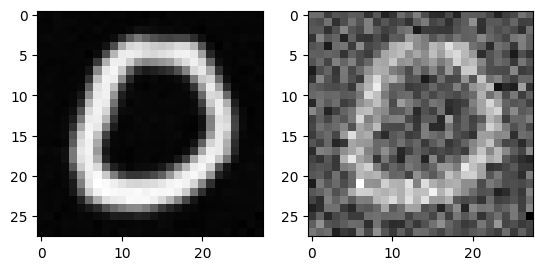

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015249133
batch loss value:  0.012260839
batch loss value:  0.014369814
batch loss value:  0.017258838
batch loss value:  0.015281877
batch loss value:  0.0138384085
batch loss value:  0.013478599
batch loss value:  0.014469302
batch loss value:  0.018779427
batch loss value:  0.017391661
iteration: 4300 loss: 0.035321
time step for image:  49  label:  [44]


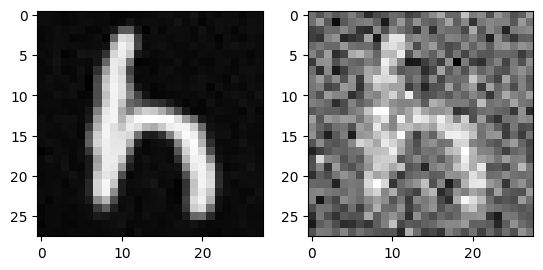

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013555121
batch loss value:  0.01709884
batch loss value:  0.014433803
batch loss value:  0.012235543
batch loss value:  0.019510787
batch loss value:  0.014384568
batch loss value:  0.017720636
batch loss value:  0.013821181
batch loss value:  0.016492328
batch loss value:  0.01627661
iteration: 4400 loss: 0.034772
time step for image:  23  label:  [1]


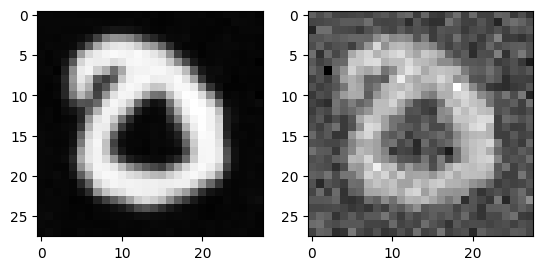

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016180985
batch loss value:  0.013279407
batch loss value:  0.013608537
batch loss value:  0.016869498
batch loss value:  0.017236985
batch loss value:  0.01409567
batch loss value:  0.016258588
batch loss value:  0.012990428
batch loss value:  0.010472528
batch loss value:  0.01704537
iteration: 4500 loss: 0.035264
time step for image:  45  label:  [19]


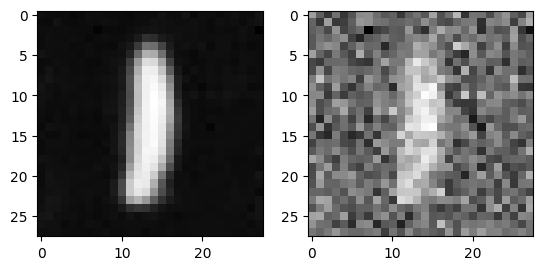

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.0151863955
batch loss value:  0.01820175
batch loss value:  0.017322553
batch loss value:  0.013486172
batch loss value:  0.01620521
batch loss value:  0.014795799
batch loss value:  0.014461709
batch loss value:  0.016879197
batch loss value:  0.01514349
batch loss value:  0.016323663
iteration: 4600 loss: 0.034389
time step for image:  10  label:  [44]


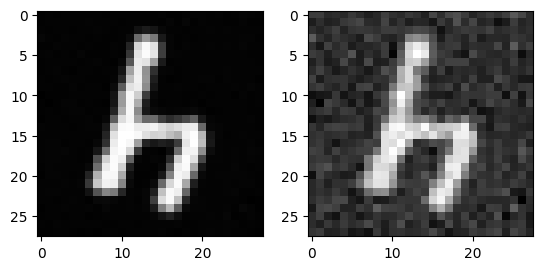

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013222963
batch loss value:  0.016287189
batch loss value:  0.018680021
batch loss value:  0.0129008815
batch loss value:  0.014156858
batch loss value:  0.016929334
saving iteration: 4660 loss: 0.034026
batch loss value:  0.016840909
batch loss value:  0.015053777
batch loss value:  0.015473563
batch loss value:  0.019214474
iteration: 4700 loss: 0.034203
time step for image:  36  label:  [50]


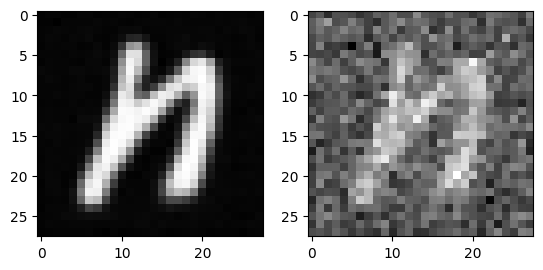

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016192002
batch loss value:  0.012872227
batch loss value:  0.016936637
batch loss value:  0.018407958
batch loss value:  0.015160398
batch loss value:  0.012928016
batch loss value:  0.016380828
batch loss value:  0.015992017
batch loss value:  0.015147032
batch loss value:  0.010229643
iteration: 4800 loss: 0.035255
time step for image:  38  label:  [3]


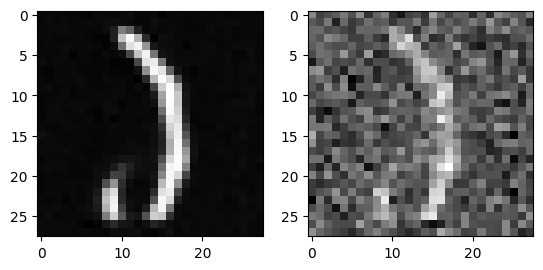

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01339408
batch loss value:  0.016250217
batch loss value:  0.016631238
batch loss value:  0.012920577
batch loss value:  0.015533391
batch loss value:  0.013731567
batch loss value:  0.015810827
batch loss value:  0.017035201
batch loss value:  0.012846114
batch loss value:  0.013238294
iteration: 4900 loss: 0.034530
time step for image:  16  label:  [3]


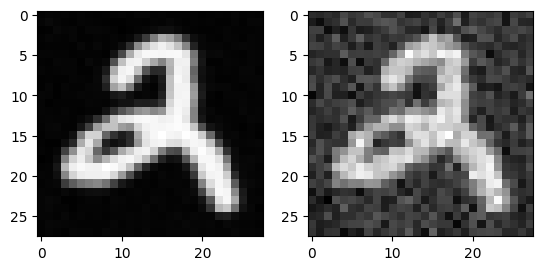

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.0135844005
batch loss value:  0.013883725
batch loss value:  0.015495248
batch loss value:  0.014252466
batch loss value:  0.014019781
batch loss value:  0.016874712
batch loss value:  0.012407132
batch loss value:  0.01367557
batch loss value:  0.015306115
batch loss value:  0.016005967
iteration: 5000 loss: 0.034235
time step for image:  37  label:  [1]


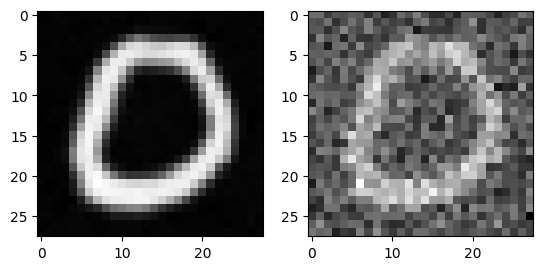

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013146361
batch loss value:  0.01487007
batch loss value:  0.01604968
batch loss value:  0.018017258
batch loss value:  0.0153934825
batch loss value:  0.01881443
batch loss value:  0.013928894
batch loss value:  0.011080464
batch loss value:  0.01802937
batch loss value:  0.014391991
iteration: 5100 loss: 0.036367
time step for image:  35  label:  [7]


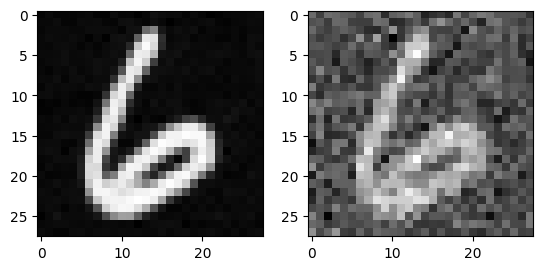

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013443068
batch loss value:  0.016618414
batch loss value:  0.014674731
batch loss value:  0.015172165
batch loss value:  0.014887412
batch loss value:  0.017139284
batch loss value:  0.012309926
batch loss value:  0.01670506
batch loss value:  0.01647156
batch loss value:  0.01519047
iteration: 5200 loss: 0.034242
time step for image:  52  label:  [56]


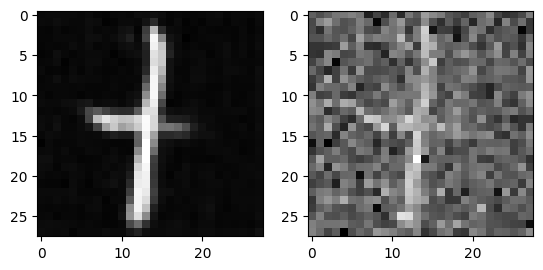

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014566075
batch loss value:  0.013440414
batch loss value:  0.015538935
batch loss value:  0.016250484
batch loss value:  0.011328343
batch loss value:  0.014382964
batch loss value:  0.014784522
batch loss value:  0.014374769
batch loss value:  0.013817041
batch loss value:  0.017356608
iteration: 5300 loss: 0.034840
time step for image:  33  label:  [50]


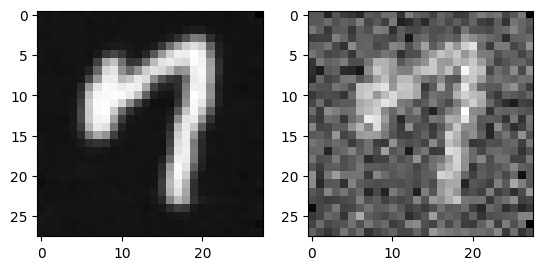

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.011258485
batch loss value:  0.014186474
saving iteration: 5320 loss: 0.033710
batch loss value:  0.01351884
batch loss value:  0.016170856
batch loss value:  0.013416693
batch loss value:  0.014863481
batch loss value:  0.017394325
batch loss value:  0.014542539
batch loss value:  0.012806769
batch loss value:  0.014230692
iteration: 5400 loss: 0.035844
time step for image:  28  label:  [9]


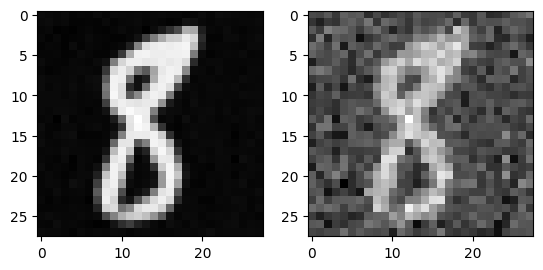

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015206928
batch loss value:  0.014987083
batch loss value:  0.016819345
batch loss value:  0.014376664
batch loss value:  0.015688188
batch loss value:  0.014075305
batch loss value:  0.014299045
batch loss value:  0.011752451
saving iteration: 5480 loss: 0.033247
batch loss value:  0.017927205
batch loss value:  0.013506258
iteration: 5500 loss: 0.033909
time step for image:  24  label:  [40]


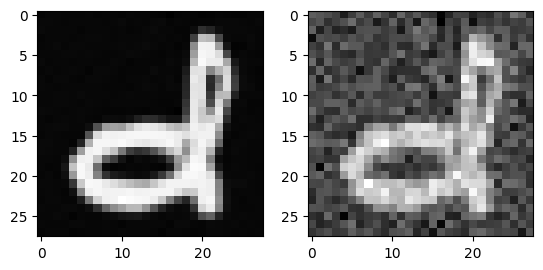

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014732388
batch loss value:  0.013698019
batch loss value:  0.012592593
batch loss value:  0.013744371
batch loss value:  0.012005404
batch loss value:  0.012096047
batch loss value:  0.014957879
batch loss value:  0.014236674
batch loss value:  0.015914533
batch loss value:  0.014514828
iteration: 5600 loss: 0.034205
time step for image:  32  label:  [40]


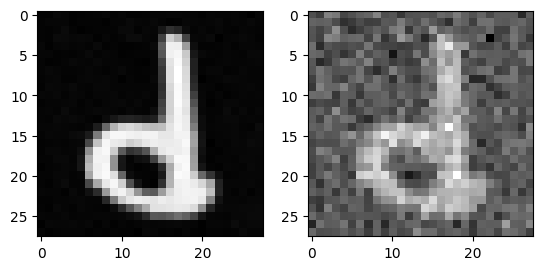

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01192805
batch loss value:  0.014520603
batch loss value:  0.012689883
batch loss value:  0.014214126
batch loss value:  0.014041711
batch loss value:  0.016866162
batch loss value:  0.013933475
batch loss value:  0.015079216
batch loss value:  0.014296962
batch loss value:  0.014838564
iteration: 5700 loss: 0.033533
time step for image:  39  label:  [19]


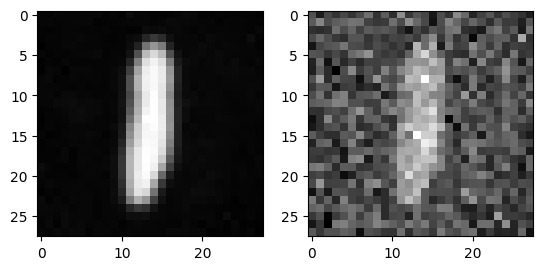

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015251318
batch loss value:  0.015480876
batch loss value:  0.019325834
batch loss value:  0.012813553
batch loss value:  0.012979684
batch loss value:  0.012084303
batch loss value:  0.012928529
batch loss value:  0.014111818
batch loss value:  0.014448177
batch loss value:  0.013847062
iteration: 5800 loss: 0.035116
time step for image:  54  label:  [15]


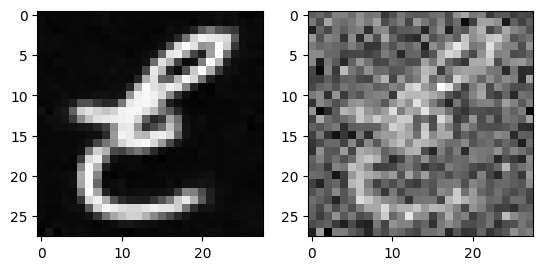

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013656478
batch loss value:  0.015926719
batch loss value:  0.014220744
batch loss value:  0.015480485
batch loss value:  0.014416026
batch loss value:  0.01343097
batch loss value:  0.012846779
batch loss value:  0.015284654
batch loss value:  0.014892493
batch loss value:  0.014557908
iteration: 5900 loss: 0.033704
time step for image:  44  label:  [18]


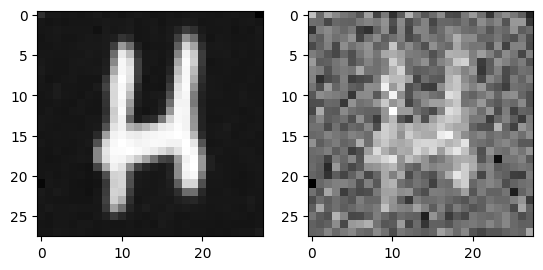

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014610542
batch loss value:  0.012550814
batch loss value:  0.012679831
batch loss value:  0.012040144
batch loss value:  0.012840759
batch loss value:  0.011853291
batch loss value:  0.015124252
batch loss value:  0.012583729
batch loss value:  0.019971963
batch loss value:  0.012166453
iteration: 6000 loss: 0.035019
time step for image:  53  label:  [3]


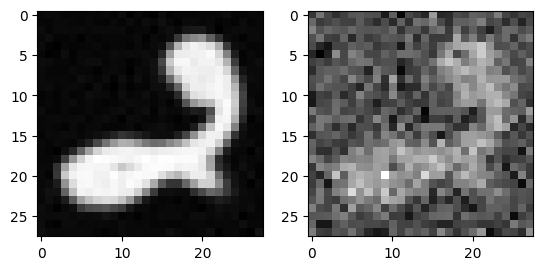

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.012874569
batch loss value:  0.013891239
batch loss value:  0.013916206
batch loss value:  0.015880799
batch loss value:  0.016119795
batch loss value:  0.0108107645
saving iteration: 6060 loss: 0.033236
batch loss value:  0.014705292
batch loss value:  0.01638145
batch loss value:  0.017476581
batch loss value:  0.016160902
iteration: 6100 loss: 0.033638
time step for image:  30  label:  [27]


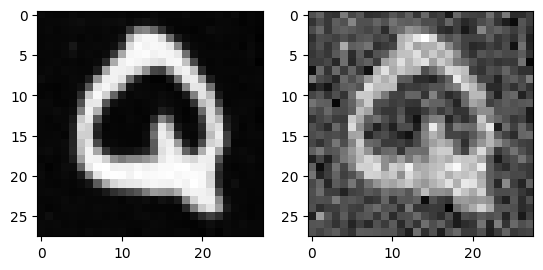

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.011016481
batch loss value:  0.015284743
batch loss value:  0.014898008
batch loss value:  0.01641057
batch loss value:  0.016670609
batch loss value:  0.016287241
batch loss value:  0.019594658
batch loss value:  0.01722785
batch loss value:  0.013759075
batch loss value:  0.0151340775
iteration: 6200 loss: 0.034175
time step for image:  59  label:  [8]


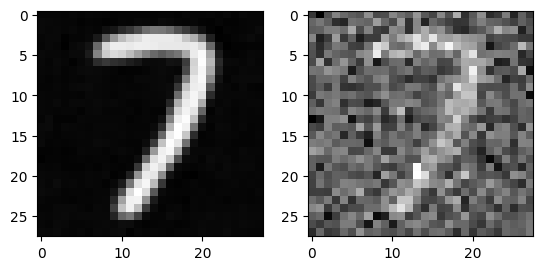

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01325417
batch loss value:  0.013083784
batch loss value:  0.015736762
batch loss value:  0.016283317
batch loss value:  0.014070395
batch loss value:  0.015193594
batch loss value:  0.015304228
batch loss value:  0.011121118
batch loss value:  0.015542824
batch loss value:  0.015575847
iteration: 6300 loss: 0.034216
time step for image:  32  label:  [40]


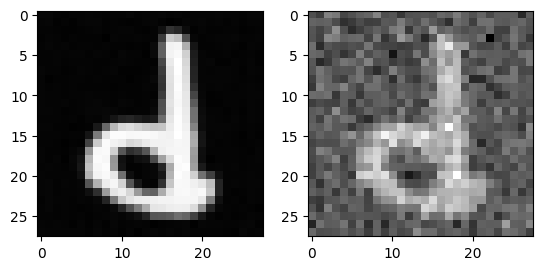

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015424346
batch loss value:  0.016208388
batch loss value:  0.017316386
batch loss value:  0.013774129
batch loss value:  0.010515105
batch loss value:  0.01412287
batch loss value:  0.0133896405
batch loss value:  0.012890777
batch loss value:  0.0130438255
batch loss value:  0.01622089
iteration: 6400 loss: 0.033371
time step for image:  7  label:  [8]


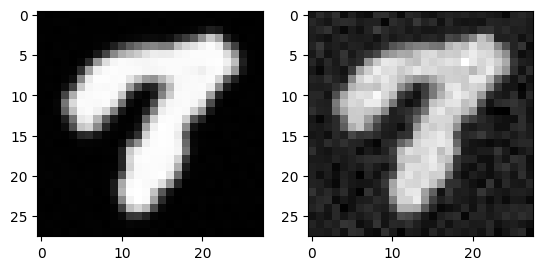

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016989395
batch loss value:  0.01644539
batch loss value:  0.013694444
batch loss value:  0.011548407
batch loss value:  0.014759718
batch loss value:  0.0148045495
batch loss value:  0.016178243
batch loss value:  0.018026793
batch loss value:  0.014080979
batch loss value:  0.013418391
iteration: 6500 loss: 0.035127
time step for image:  35  label:  [7]


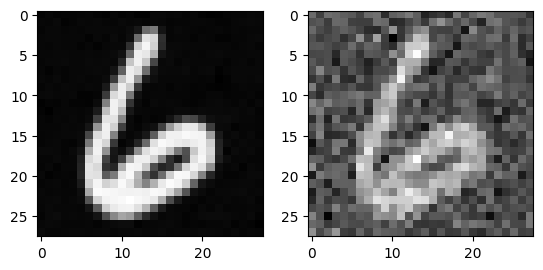

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015682686
batch loss value:  0.012760605
batch loss value:  0.015783474
batch loss value:  0.015941296
batch loss value:  0.012716413
batch loss value:  0.015509124
batch loss value:  0.014631223
batch loss value:  0.016125366
batch loss value:  0.011596646
batch loss value:  0.011119669
iteration: 6600 loss: 0.033932
time step for image:  53  label:  [3]


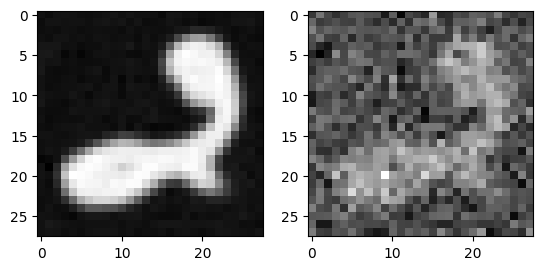

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.011267841
batch loss value:  0.015353718
batch loss value:  0.012924758
batch loss value:  0.013752982
batch loss value:  0.011688879
batch loss value:  0.015392335
batch loss value:  0.01660958
batch loss value:  0.014698338
batch loss value:  0.018586142
batch loss value:  0.014614478
iteration: 6700 loss: 0.034542
time step for image:  28  label:  [9]


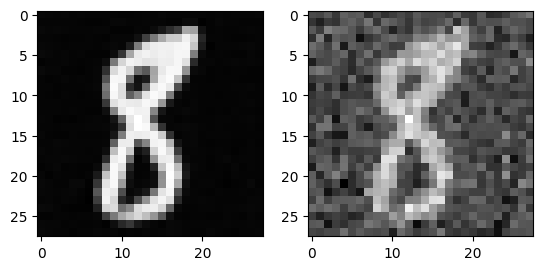

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013020484
batch loss value:  0.014757555
batch loss value:  0.012762589
batch loss value:  0.015102342
batch loss value:  0.014768096
batch loss value:  0.017329853
batch loss value:  0.013081249
batch loss value:  0.013795188
batch loss value:  0.014442415
batch loss value:  0.012323029
iteration: 6800 loss: 0.033956
time step for image:  11  label:  [2]


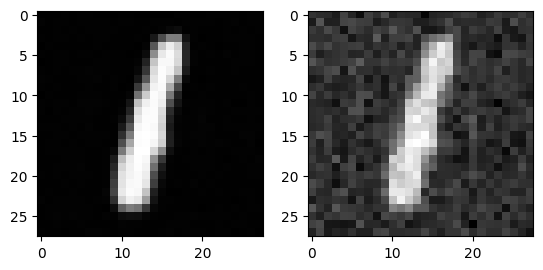

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015620578
batch loss value:  0.01278601
batch loss value:  0.014870325
batch loss value:  0.014521938
batch loss value:  0.013029003
batch loss value:  0.01219314
batch loss value:  0.011904211
batch loss value:  0.014830647
batch loss value:  0.012452274
batch loss value:  0.011647445
iteration: 6900 loss: 0.033337
time step for image:  26  label:  [38]


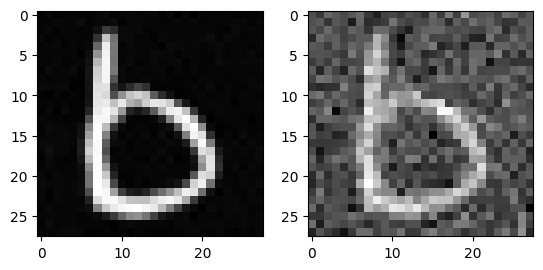

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.012475096
batch loss value:  0.012616039
batch loss value:  0.014056314
batch loss value:  0.018063014
batch loss value:  0.012909479
batch loss value:  0.015521308
batch loss value:  0.011121932
batch loss value:  0.0141508775
saving iteration: 6980 loss: 0.032888
batch loss value:  0.012768931
batch loss value:  0.014725771
iteration: 7000 loss: 0.033177
time step for image:  63  label:  [10]


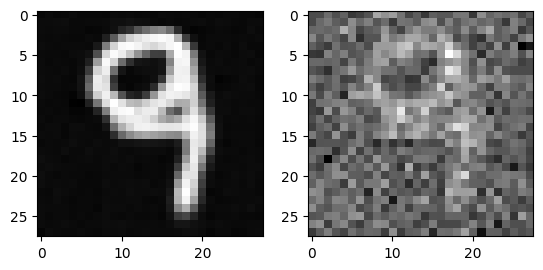

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.0141838165
batch loss value:  0.013155137
batch loss value:  0.018779293
batch loss value:  0.01498748
batch loss value:  0.014716612
batch loss value:  0.017276838
saving iteration: 7060 loss: 0.032866
batch loss value:  0.014573288
batch loss value:  0.013967097
batch loss value:  0.013549946
batch loss value:  0.01665595
iteration: 7100 loss: 0.034357
time step for image:  13  label:  [2]


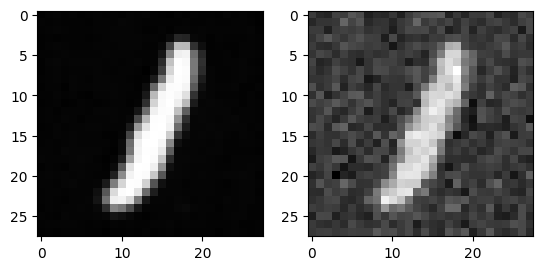

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014728052
batch loss value:  0.015754554
batch loss value:  0.014729361
batch loss value:  0.017873228
batch loss value:  0.013718718
batch loss value:  0.012225719
batch loss value:  0.016794745
batch loss value:  0.011634574
batch loss value:  0.013918608
batch loss value:  0.014010837
iteration: 7200 loss: 0.033256
time step for image:  44  label:  [18]


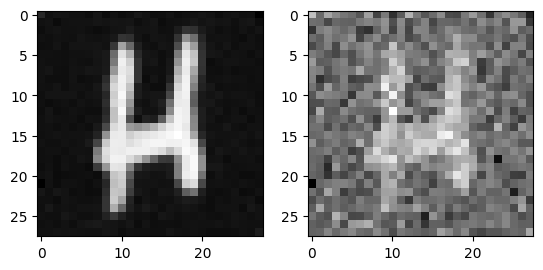

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.018208593
batch loss value:  0.014044935
batch loss value:  0.014306107
batch loss value:  0.013008603
saving iteration: 7240 loss: 0.032832
batch loss value:  0.011768667
batch loss value:  0.012588922
batch loss value:  0.015152853
batch loss value:  0.013052382
batch loss value:  0.017140733
batch loss value:  0.016236722
iteration: 7300 loss: 0.033252
time step for image:  45  label:  [19]


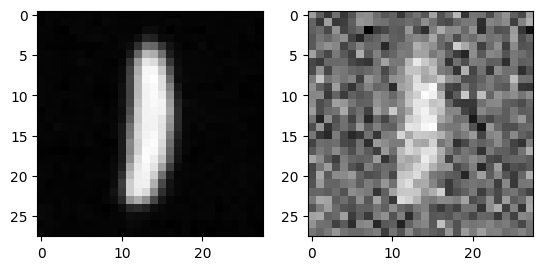

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.018775482
batch loss value:  0.012483019
batch loss value:  0.014674783
batch loss value:  0.01405988
batch loss value:  0.013254404
batch loss value:  0.009948642
batch loss value:  0.015523566
batch loss value:  0.013865063
batch loss value:  0.016165752
batch loss value:  0.013748962
iteration: 7400 loss: 0.034350
time step for image:  9  label:  [7]


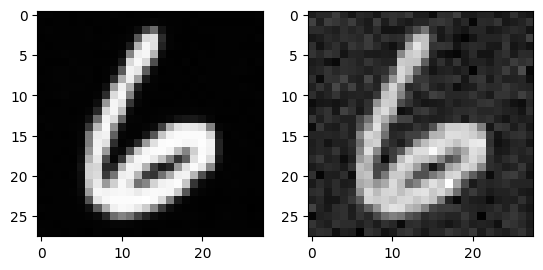

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013526487
batch loss value:  0.013692544
batch loss value:  0.014262536
batch loss value:  0.016893705
batch loss value:  0.018252745
batch loss value:  0.015963491
batch loss value:  0.0149461385
batch loss value:  0.012512447
saving iteration: 7480 loss: 0.032584
batch loss value:  0.015453153
batch loss value:  0.016785946
iteration: 7500 loss: 0.033547
time step for image:  9  label:  [7]


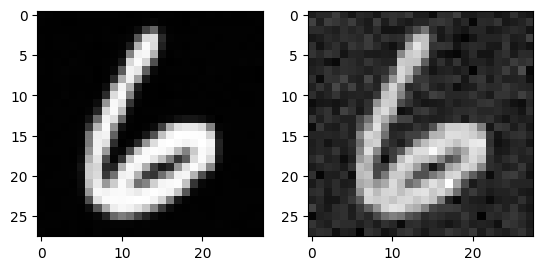

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016189704
batch loss value:  0.015138463
batch loss value:  0.011773493
batch loss value:  0.016031578
batch loss value:  0.017147914
batch loss value:  0.016958209
batch loss value:  0.012085913
batch loss value:  0.012302552
batch loss value:  0.014636288
batch loss value:  0.019566134
iteration: 7600 loss: 0.034196
time step for image:  52  label:  [56]


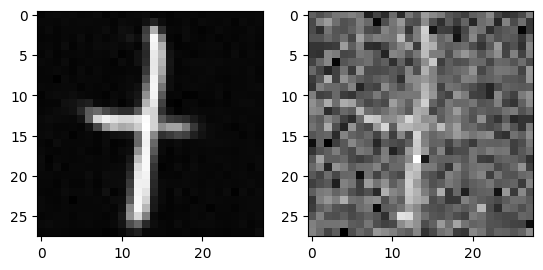

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013660079
batch loss value:  0.012490853
batch loss value:  0.0128736785
batch loss value:  0.014936402
batch loss value:  0.012776533
batch loss value:  0.011506417
batch loss value:  0.012082599
batch loss value:  0.014274603
batch loss value:  0.0159556
batch loss value:  0.011967432
iteration: 7700 loss: 0.034312
time step for image:  56  label:  [2]


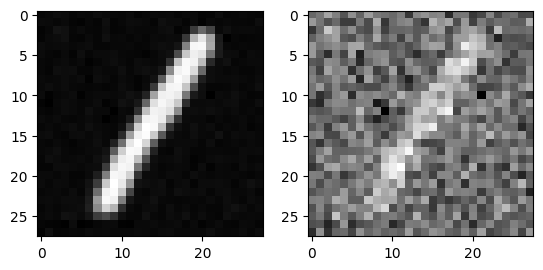

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013628412
batch loss value:  0.018501552
batch loss value:  0.015489215
batch loss value:  0.018068392
batch loss value:  0.014719402
batch loss value:  0.015831107
batch loss value:  0.013075501
batch loss value:  0.012408938
batch loss value:  0.011621378
batch loss value:  0.016489081
iteration: 7800 loss: 0.033122
time step for image:  5  label:  [43]


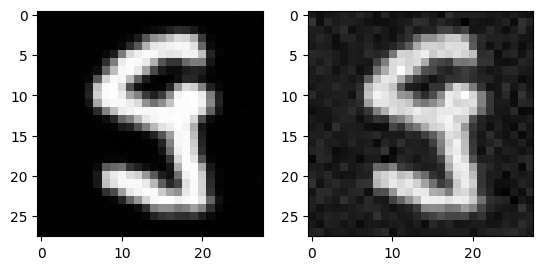

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013790278
batch loss value:  0.015083084
batch loss value:  0.014894957
batch loss value:  0.01014032
batch loss value:  0.011947166
batch loss value:  0.014794991
batch loss value:  0.012041916
batch loss value:  0.014336091
batch loss value:  0.016263094
batch loss value:  0.012575939
iteration: 7900 loss: 0.033591
time step for image:  41  label:  [1]


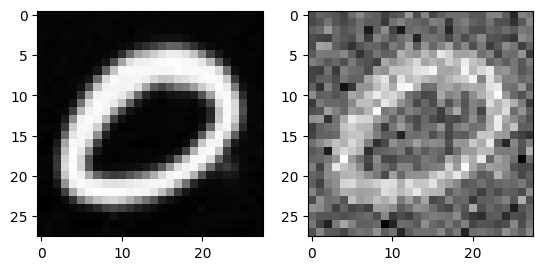

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015461154
batch loss value:  0.013938421
batch loss value:  0.017020702
batch loss value:  0.014863465
batch loss value:  0.018516771
batch loss value:  0.016206952
batch loss value:  0.01351027
batch loss value:  0.014074202
batch loss value:  0.013195623
batch loss value:  0.014280234
iteration: 8000 loss: 0.032850
time step for image:  60  label:  [16]


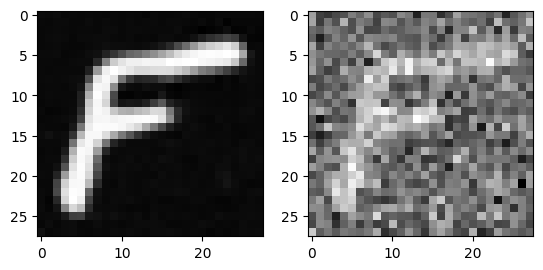

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016639728
batch loss value:  0.013138356
batch loss value:  0.012811245
batch loss value:  0.015746053
batch loss value:  0.013103899
batch loss value:  0.01614372
batch loss value:  0.011833504
batch loss value:  0.012616988
batch loss value:  0.015636278
batch loss value:  0.016505163
iteration: 8100 loss: 0.032852
time step for image:  25  label:  [4]


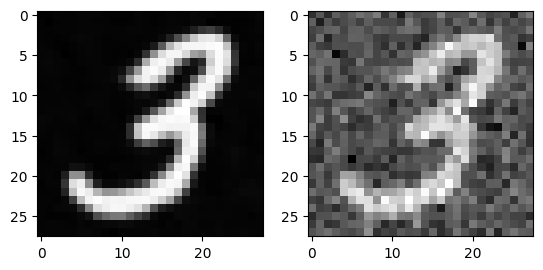

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.01540808
batch loss value:  0.012029143
saving iteration: 8120 loss: 0.032562
batch loss value:  0.015674056
batch loss value:  0.01732923
batch loss value:  0.013774552
batch loss value:  0.015726838
batch loss value:  0.014394617
batch loss value:  0.013174476
batch loss value:  0.01166377
batch loss value:  0.0136470925
iteration: 8200 loss: 0.033302
time step for image:  59  label:  [8]


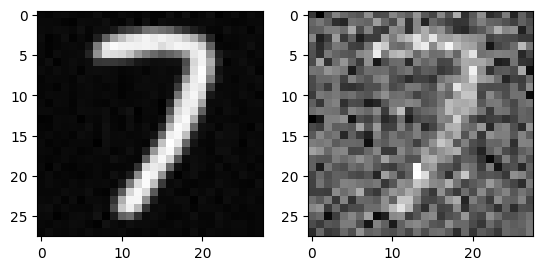

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.017314935
batch loss value:  0.012757356
saving iteration: 8220 loss: 0.032531
batch loss value:  0.012861801
batch loss value:  0.015357754
batch loss value:  0.0154806655
batch loss value:  0.014754968
batch loss value:  0.011503218
batch loss value:  0.016390264
batch loss value:  0.0154381655
batch loss value:  0.012396886
iteration: 8300 loss: 0.032807
time step for image:  40  label:  [10]


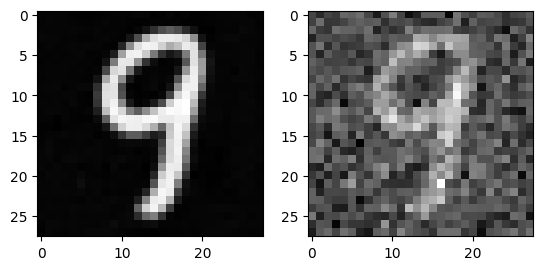

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013488567
batch loss value:  0.013503207
batch loss value:  0.013603554
batch loss value:  0.014065635
batch loss value:  0.015142416
batch loss value:  0.017491834
batch loss value:  0.015021992
batch loss value:  0.012746939
saving iteration: 8380 loss: 0.032361
batch loss value:  0.010929609
batch loss value:  0.013353439
iteration: 8400 loss: 0.032391
time step for image:  13  label:  [2]


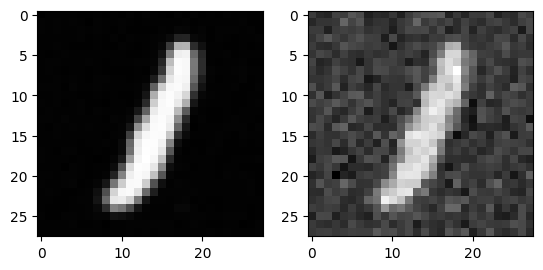

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.012782041
batch loss value:  0.012126171
batch loss value:  0.015001824
batch loss value:  0.014390861
batch loss value:  0.014658416
batch loss value:  0.012033228
batch loss value:  0.0147903245
batch loss value:  0.013536712
batch loss value:  0.014198165
batch loss value:  0.0134969335
iteration: 8500 loss: 0.032416
time step for image:  60  label:  [16]


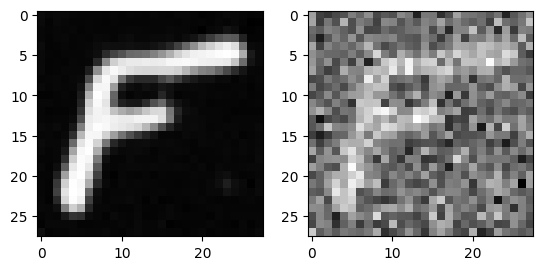

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.012502298
batch loss value:  0.018691722
batch loss value:  0.012059859
batch loss value:  0.014379116
batch loss value:  0.012089494
batch loss value:  0.019864105
batch loss value:  0.012630842
batch loss value:  0.017724968
batch loss value:  0.013016442
batch loss value:  0.014999927
iteration: 8600 loss: 0.033300
time step for image:  48  label:  [16]


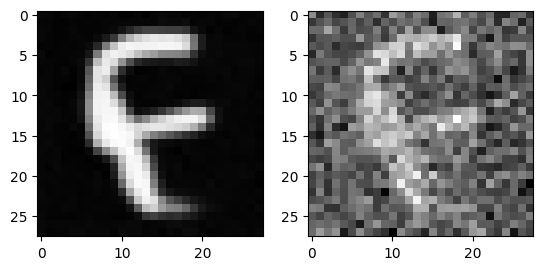

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.013373729
batch loss value:  0.015224105
batch loss value:  0.015441523
batch loss value:  0.012378488
batch loss value:  0.0167257
batch loss value:  0.015020361
batch loss value:  0.012975978
batch loss value:  0.012700771
batch loss value:  0.01288221
batch loss value:  0.013812054
iteration: 8700 loss: 0.033127
time step for image:  35  label:  [7]


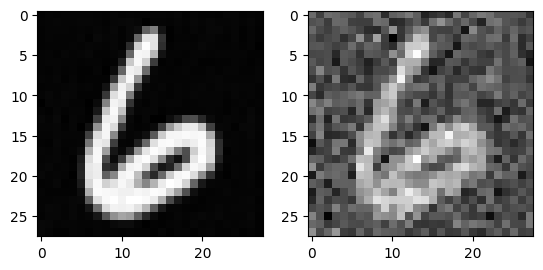

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015656548
batch loss value:  0.014232373
batch loss value:  0.015797226
batch loss value:  0.017034922
batch loss value:  0.014742609
batch loss value:  0.014045073
batch loss value:  0.016010147
batch loss value:  0.016694887
batch loss value:  0.011330383
batch loss value:  0.015574924
saving iteration: 8800 loss: 0.032348
iteration: 8800 loss: 0.032348
time step for image:  48  label:  [16]


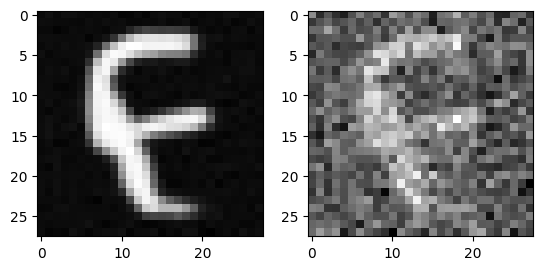

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.016201084
batch loss value:  0.014128196
batch loss value:  0.016351981
batch loss value:  0.012603426
batch loss value:  0.012859156
batch loss value:  0.01346869
batch loss value:  0.0133673465
batch loss value:  0.016169265
batch loss value:  0.017730564
batch loss value:  0.014240981
iteration: 8900 loss: 0.034001
time step for image:  17  label:  [1]


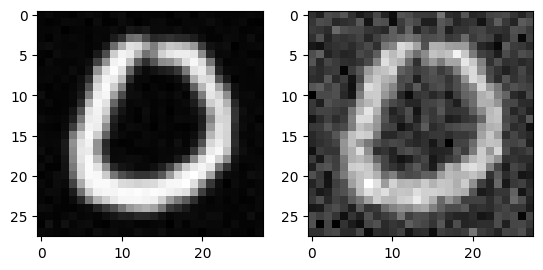

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014980836
batch loss value:  0.01324873
batch loss value:  0.018375795
batch loss value:  0.013203103
batch loss value:  0.011660451
batch loss value:  0.016127888
batch loss value:  0.011827348
batch loss value:  0.016013883
batch loss value:  0.011009249
batch loss value:  0.01576848
saving iteration: 9000 loss: 0.032301
iteration: 9000 loss: 0.032301
time step for image:  26  label:  [38]


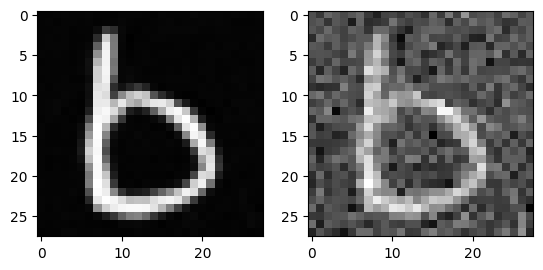

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.011413318
batch loss value:  0.011269864
batch loss value:  0.0138851125
batch loss value:  0.01492555
saving iteration: 9040 loss: 0.032210
batch loss value:  0.013241321
batch loss value:  0.014301762
batch loss value:  0.013779641
batch loss value:  0.009521471
batch loss value:  0.014137697
batch loss value:  0.014944229
iteration: 9100 loss: 0.032741
time step for image:  44  label:  [18]


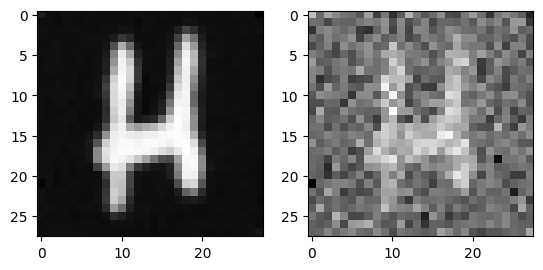

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014230661
batch loss value:  0.013439782
batch loss value:  0.012662148
batch loss value:  0.01385718
batch loss value:  0.011528936
batch loss value:  0.012227457
batch loss value:  0.01189472
batch loss value:  0.012194401
batch loss value:  0.01380145
batch loss value:  0.013209537
iteration: 9200 loss: 0.032573
time step for image:  51  label:  [37]


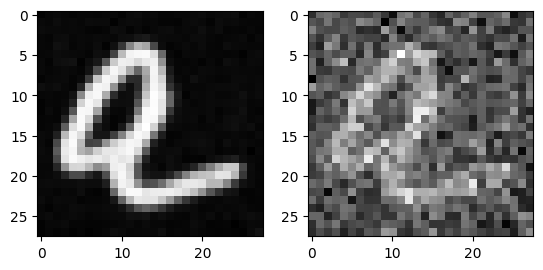

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.012815095
batch loss value:  0.013806371
batch loss value:  0.012828458
batch loss value:  0.011244236
batch loss value:  0.013311397
batch loss value:  0.013804512
batch loss value:  0.019769017
batch loss value:  0.0148541285
batch loss value:  0.020416547
batch loss value:  0.014407255
iteration: 9300 loss: 0.034479
time step for image:  6  label:  [8]


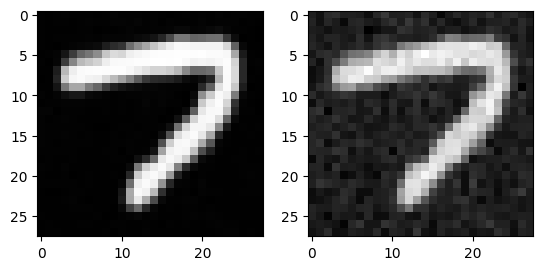

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.015141692
batch loss value:  0.01348532
batch loss value:  0.01495117
batch loss value:  0.013506906
batch loss value:  0.014746882
batch loss value:  0.012240795
batch loss value:  0.013279096
batch loss value:  0.012941867
batch loss value:  0.013275554
batch loss value:  0.013400224
iteration: 9400 loss: 0.032430
time step for image:  58  label:  [37]


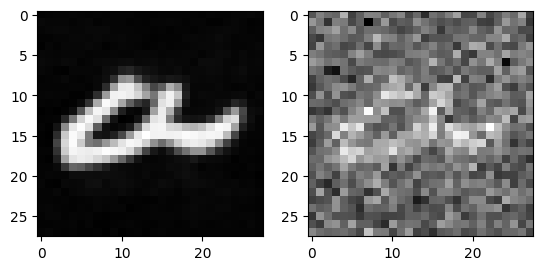

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014266964
batch loss value:  0.012852561
saving iteration: 9420 loss: 0.032150
batch loss value:  0.014083341
batch loss value:  0.014319892
batch loss value:  0.012316316
batch loss value:  0.014730282
batch loss value:  0.012631004
batch loss value:  0.014124127
batch loss value:  0.013834361
batch loss value:  0.01377314
iteration: 9500 loss: 0.032359
time step for image:  8  label:  [9]


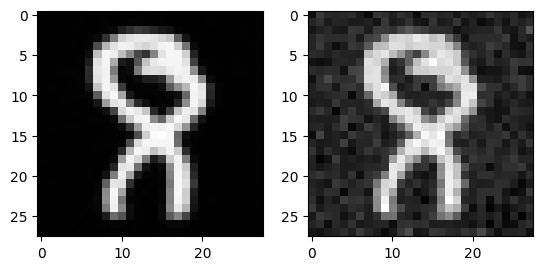

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014787319
batch loss value:  0.018265033
batch loss value:  0.014923736
batch loss value:  0.012412548
saving iteration: 9540 loss: 0.031914
batch loss value:  0.013806928
batch loss value:  0.0138970455
batch loss value:  0.015650934
batch loss value:  0.011393831
batch loss value:  0.01504638
batch loss value:  0.012888464
iteration: 9600 loss: 0.033247
time step for image:  8  label:  [9]


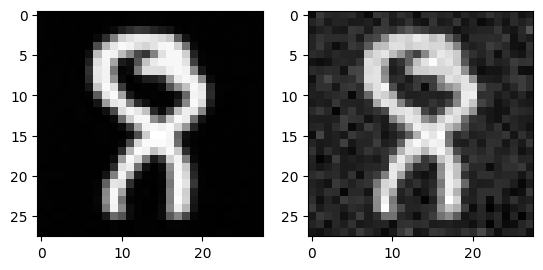

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.011775193
batch loss value:  0.012943953
batch loss value:  0.012529248
batch loss value:  0.013632449
batch loss value:  0.015690947
batch loss value:  0.016897457
saving iteration: 9660 loss: 0.031758
batch loss value:  0.011880908
batch loss value:  0.01573154
batch loss value:  0.0118706
batch loss value:  0.014531135
iteration: 9700 loss: 0.033058
time step for image:  36  label:  [50]


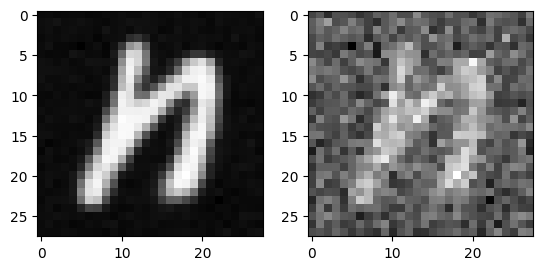

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014650423
batch loss value:  0.011786012
batch loss value:  0.012027932
batch loss value:  0.013140272
batch loss value:  0.013953945
batch loss value:  0.014010408
batch loss value:  0.012396152
batch loss value:  0.014188338
batch loss value:  0.012389463
batch loss value:  0.014501374
iteration: 9800 loss: 0.032310
time step for image:  24  label:  [40]


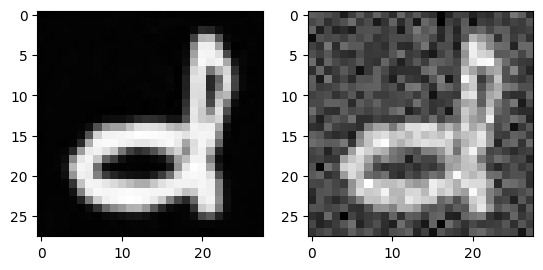

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.011037035
batch loss value:  0.014937025
batch loss value:  0.018712848
batch loss value:  0.01519682
batch loss value:  0.012305705
batch loss value:  0.014065044
batch loss value:  0.015610402
batch loss value:  0.011740332
batch loss value:  0.014257794
batch loss value:  0.015264362
iteration: 9900 loss: 0.032752
time step for image:  11  label:  [2]


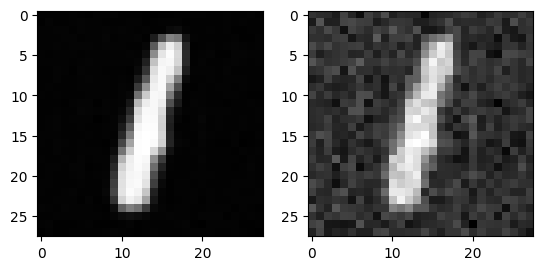

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

batch loss value:  0.014086266
batch loss value:  0.011715992
batch loss value:  0.015957318
batch loss value:  0.012894081
batch loss value:  0.015157191
batch loss value:  0.013237917
batch loss value:  0.013583088
batch loss value:  0.015733898
batch loss value:  0.013600035


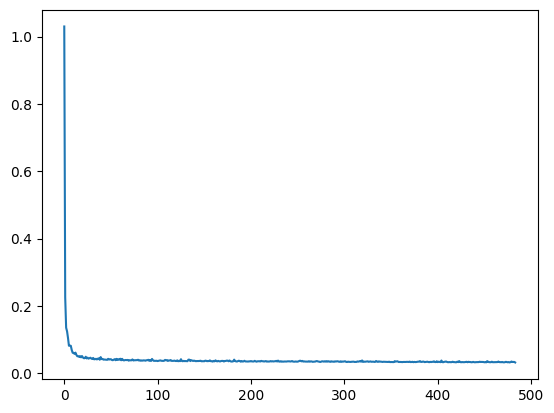

In [24]:
data_noisy, data_in_batch, timestep, losses, avg_params, state = train_model(opt_state, params, avg_params, state, model_name, train_new_model = train_new_model, energy_method=False)
plt.plot(losses)

In [25]:
def param_count(pytree):
  return sum(x.size for x in jax.tree_util.tree_leaves(pytree))

param_count(avg_params)

2233714

## Full generation model

In [26]:
mean_coeff_1 = jnp.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = jnp.sqrt(alphas_prev_) * betas / variance

In [27]:
import random

def generate_data(avg_params, state, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, timesteps+1)
    
    # need to generate new keys everytime
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy

    for t in range(1, timesteps+1):
        timestep = timesteps-t
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data, _ = net.apply(avg_params, state, data_in_batch, t_repeated, label, is_training=False)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas[timestep])) - jnp.log(sd[timestep]))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(alphas[timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas[timestep])/jnp.sqrt(alphas[timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)

        posterior_data = posterior_variance_corrected[timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [28]:
batch_size_generation = 64
datas, data_in_batch = generate_data(avg_params, state, label=jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

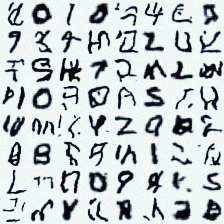

In [29]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

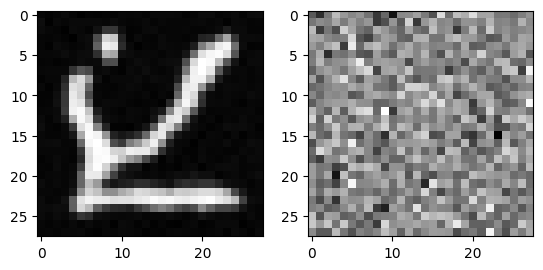

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [30]:
_, (plt1, plt2) = plt.subplots(1, 2)
tt = random.randint(0, batch_size_generation-1)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)
# show_image((data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [31]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, timesteps, 10):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_full_with_cond.gif', writer='pillow')

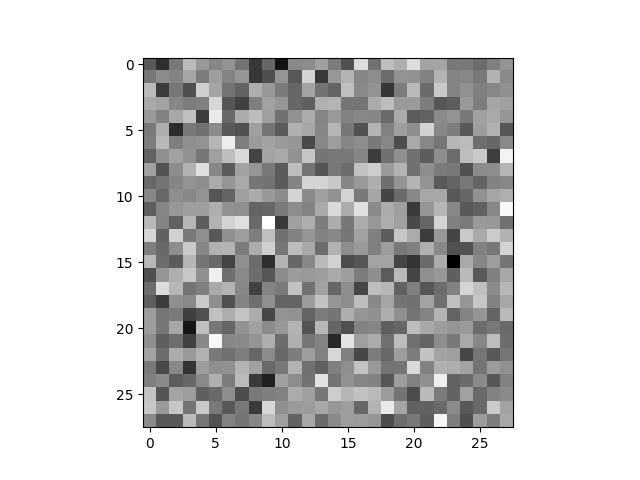

In [32]:
with open(gifs_dir + 'diffusion_generation_full_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

## strided sampling

In [33]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 5)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [34]:
mean_coeff_1_strided = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2_strided = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [35]:
import random

def generate_data_strided(avg_params, state, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, len(strided_schedule)+1)
    
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
          
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy                               
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data, _ = net.apply(avg_params, state, data_in_batch, t_repeated, label, is_training=False)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1_strided[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2_strided[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [36]:
batch_size_generation = 64
datas, data_in_batch = generate_data_strided(avg_params, state, label= jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

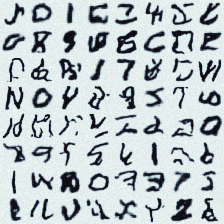

In [37]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

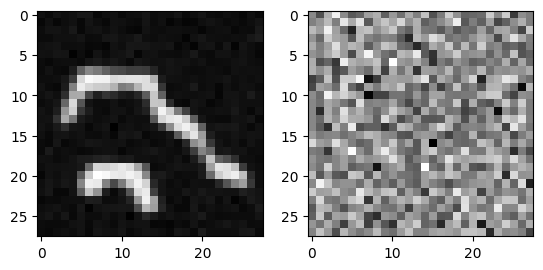

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [38]:
_, (plt1, plt2) = plt.subplots(1, 2)

tt = random.randint(0, batch_size_generation-1)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [39]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, len(strided_schedule)):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_strided_with_cond.gif', writer='pillow')

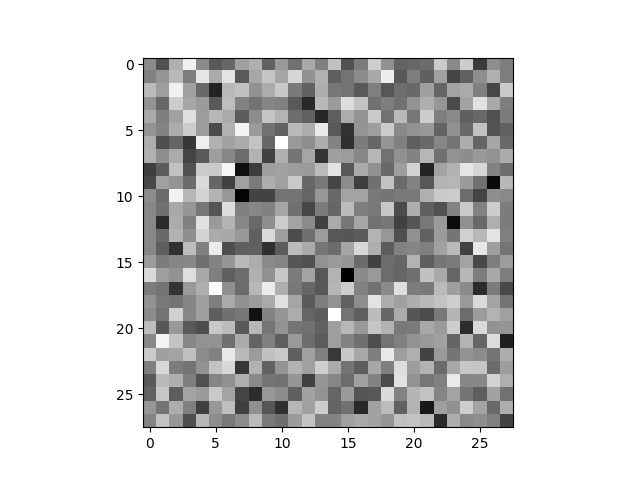

In [40]:
with open(gifs_dir + 'diffusion_generation_strided_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [41]:
import string

x = list(range(1, 63))
y = [str(i) for i in (list(range(0, 10)))] + list(string.ascii_uppercase + string.ascii_lowercase)

dict_ = {}
for i in x:
  dict_[y[i-1]] = i
  
def get_label(ans):
  return jnp.array([dict_[str.upper(char)] for char in ans])

answer = []
answer.append(get_label("varun"))
answer.append(get_label("tulsian"))
answer.append(get_label("2001"))
answer.append(get_label("gmail"))
answer.append(get_label("com"))

In [42]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data(avg_params, state, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data(avg_params, state, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [43]:
_, d = generate_data(avg_params, state, label= answer[0], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [44]:
_, d = generate_data(avg_params, state, label= answer[1], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [45]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data_strided(avg_params, state, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data_strided(avg_params, state, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [46]:
datas, d = generate_data_strided(avg_params, state, label= answer[0], energy_method=False, clipped_version=True)
datas_ = jnp.clip(jnp.array(datas[0:-1:2]), 0., 1.)
d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 

rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

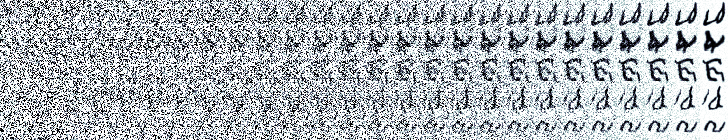

In [47]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=5), cmap='bone_r')

In [48]:
datas, d = generate_data_strided(avg_params, state, label= answer[1], energy_method=False, clipped_version=True)
datas_ = jnp.clip(jnp.array(datas[0:-1:2]), 0., 1.)
d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 
rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

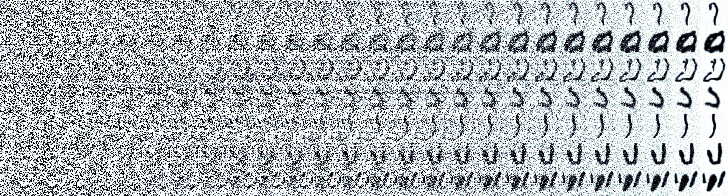

In [49]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=7), cmap='bone_r')

([<matplotlib.lines.Line2D at 0x7fc9e0692010>],
 [<matplotlib.lines.Line2D at 0x7fca80254a90>])

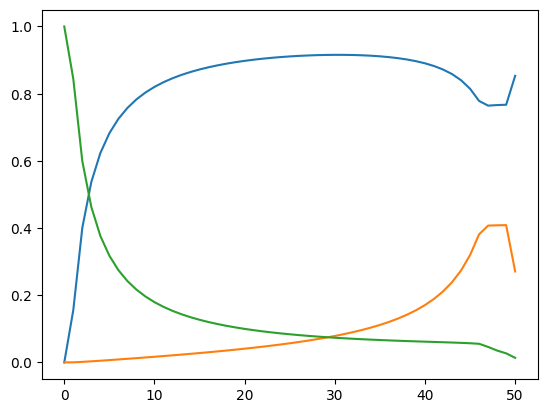

In [50]:
plt.plot(mean_coeff_1_strided), plt.plot(posterior_variance_new_schedule_corrected), plt.plot(mean_coeff_2_strided)

([<matplotlib.lines.Line2D at 0x7fc9e4df19d0>],
 [<matplotlib.lines.Line2D at 0x7fc9e4f66d90>])

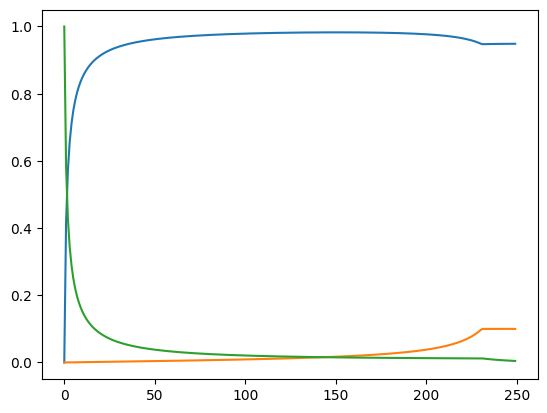

In [51]:
plt.plot(mean_coeff_1), plt.plot(posterior_variance_corrected), plt.plot(mean_coeff_2)